In [2]:
import math
import numpy as np
import random
from time import time

import pandas as pd
from downcast import reduce

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb

import optuna

from model import Autoencoder, Regressor
import torch
from torch import nn, optim
from utils import *

# PREPARE FEATURE SETS

In [3]:
IOWA_PATH = '../../datasets/train_data_iowa.csv'
CF_PATH = "../../datasets/crafted_features.csv"

In [4]:
features = [
    "location",
    "location_x", "location_y",
    "restaurant_location_x", "restaurant_location_y", 
    "order_time",
    "etd",
    "restaurant_queue",
    "max_pre_shift",
    "max_post_shift",
    "restaurants_before_customer",
    "customers_before_customer",
    "len_vehicle_route_to_customer",
]

for i in range(23):
    features.append(f"vehicle_route_to_customer_pos_x_{i}")
    features.append(f"vehicle_route_to_customer_pos_y_{i}")
    features.append(f"vehicle_route_to_customer_action_{i}")
    features.append(f"vehicle_route_to_customer_time_action_{i}") 

In [5]:
# Import data
start_time = time()

usecols=[*features, "atd"]

meta = pd.read_csv(IOWA_PATH, header=0, sep=";", usecols=usecols, nrows=10)
meta = reduce(meta)
dtypes = dict(meta.dtypes)

raw = pd.read_csv(IOWA_PATH, header=0, sep=";", usecols=usecols, dtype = dtypes)

print(f"Elapsed time: {time() - start_time} seconds")
print(raw.info(verbose=False, memory_usage="deep"))
X = raw.loc[:, raw.columns != 'atd']
y = raw['atd'] - raw['etd']

pd.set_option("display.max_columns", len(raw.columns))
raw

Elapsed time: 96.93045449256897 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850469 entries, 0 to 850468
Columns: 106 entries, location to vehicle_route_to_customer_time_action_22
dtypes: float16(50), int16(4), int8(52)
memory usage: 129.8 MB
None


,location,order_time,atd,etd,restaurant_queue,max_pre_shift,max_post_shift,location_x,location_y,restaurant_location_x,restaurant_location_y,restaurants_before_customer,customers_before_customer,len_vehicle_route_to_customer,vehicle_route_to_customer_pos_x_0,vehicle_route_to_customer_pos_y_0,vehicle_route_to_customer_action_0,vehicle_route_to_customer_time_action_0,vehicle_route_to_customer_pos_x_1,vehicle_route_to_customer_pos_y_1,vehicle_route_to_customer_action_1,vehicle_route_to_customer_time_action_1,vehicle_route_to_customer_pos_x_2,vehicle_route_to_customer_pos_y_2,vehicle_route_to_customer_action_2,vehicle_route_to_customer_time_action_2,vehicle_route_to_customer_pos_x_3,vehicle_route_to_customer_pos_y_3,vehicle_route_to_customer_action_3,vehicle_route_to_customer_time_action_3,vehicle_route_to_customer_pos_x_4,vehicle_route_to_customer_pos_y_4,vehicle_route_to_customer_action_4,vehicle_route_to_customer_time_action_4,vehicle_route_to_customer_pos_x_5,vehicle_route_to_customer_pos_y_5,vehicle_route_to_customer_action_5,vehicle_route_to_customer_time_action_5,vehicle_route_to_customer_pos_x_6,vehicle_route_to_customer_pos_y_6,vehicle_route_to_customer_action_6,vehicle_route_to_customer_time_action_6,vehicle_route_to_customer_pos_x_7,vehicle_route_to_customer_pos_y_7,vehicle_route_to_customer_action_7,vehicle_route_to_customer_time_action_7,vehicle_route_to_customer_pos_x_8,vehicle_route_to_customer_pos_y_8,vehicle_route_to_customer_action_8,vehicle_route_to_customer_time_action_8,vehicle_route_to_customer_pos_x_9,vehicle_route_to_customer_pos_y_9,vehicle_route_to_customer_action_9,vehicle_route_to_customer_time_action_9,vehicle_route_to_customer_pos_x_10,vehicle_route_to_customer_pos_y_10,vehicle_route_to_customer_action_10,vehicle_route_to_customer_time_action_10,vehicle_route_to_customer_pos_x_11,vehicle_route_to_customer_pos_y_11,vehicle_route_to_customer_action_11,vehicle_route_to_customer_time_action_11,vehicle_route_to_customer_pos_x_12,vehicle_route_to_customer_pos_y_12,vehicle_route_to_customer_action_12,vehicle_route_to_customer_time_action_12,vehicle_route_to_customer_pos_x_13,vehicle_route_to_customer_pos_y_13,vehicle_route_to_customer_action_13,vehicle_route_to_customer_time_action_13,vehicle_route_to_customer_pos_x_14,vehicle_route_to_customer_pos_y_14,vehicle_route_to_customer_action_14,vehicle_route_to_customer_time_action_14,vehicle_route_to_customer_pos_x_15,vehicle_route_to_customer_pos_y_15,vehicle_route_to_customer_action_15,vehicle_route_to_customer_time_action_15,vehicle_route_to_customer_pos_x_16,vehicle_route_to_customer_pos_y_16,vehicle_route_to_customer_action_16,vehicle_route_to_customer_time_action_16,vehicle_route_to_customer_pos_x_17,vehicle_route_to_customer_pos_y_17,vehicle_route_to_customer_action_17,vehicle_route_to_customer_time_action_17,vehicle_route_to_customer_pos_x_18,vehicle_route_to_customer_pos_y_18,vehicle_route_to_customer_action_18,vehicle_route_to_customer_time_action_18,vehicle_route_to_customer_pos_x_19,vehicle_route_to_customer_pos_y_19,vehicle_route_to_customer_action_19,vehicle_route_to_customer_time_action_19,vehicle_route_to_customer_pos_x_20,vehicle_route_to_customer_pos_y_20,vehicle_route_to_customer_action_20,vehicle_route_to_customer_time_action_20,vehicle_route_to_customer_pos_x_21,vehicle_route_to_customer_pos_y_21,vehicle_route_to_customer_action_21,vehicle_route_to_customer_time_action_21,vehicle_route_to_customer_pos_x_22,vehicle_route_to_customer_pos_y_22,vehicle_route_to_customer_action_22,vehicle_route_to_customer_time_action_22
0,2097,567,583,584,8,0,0,4.562500,8.312500,4.996094,10.343750,1,1,4,4.996094,10.343750,1,4,4.996094,10.343750,3,5,4.562500,8.312500,2,5,4.562500,8.312500,4,3,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0
1,997,58

# Feature Engineering

Features used in Hildebrandt et al. (2020):
<ul>
    <li>n_stops: sum(vehicle_route_to_customer_action_i = 1 or 2)</li>
    <li>n_pickup_stops: sum(vehicle_route_to_customer_action_i = 1)</li>
    <li>n_delivery_stops: sum(vehicle_route_to_customer_action_i = 2)</li>
    <li>max_pre_shift: already given</li>    
    <li>max_post_shift: already given</li>
    <li>prep_time: already given ( == restaurant_queue)</li>
    <li>order_time: already given</li>
    <li>eta_pom: already given</li>
    <li>customer_location: already given</li>
    <li>restaurant_location: already given</li>
</ul>

Weitere:
<ul>
    <li>restaurants_before_customer : already given</li>
    <li>customers_before_customer : already given</li>
    <li>dropoff_time</li>

In [ ]:
#Define strings to identify needed columns for each feature we want to craft
query_strings = {
    #"n_stops" : ["vehicle_route_to_customer_action"],
        
    #"n_pickup_stops" : ["vehicle_route_to_customer_action"],
    
    #"n_delivery_stops" : ["vehicle_route_to_customer_action"],
    "dropoff_time" : ["vehicle_route_to_customer_action",
                      "vehicle_route_to_customer_time_action",
                      "vehicle_route_to_customer_pos_x_",
                      "vehicle_route_to_customer_pos_y_",
                      "location_x", "location_y"
                     ]
    #"cumulated_prep_time" : 
    #"cumulated_dropoff_time" :
    #"cumulated_delivery_time" : 
}

raw_feats = [
    "location_x", "location_y",
    "restaurant_location_x", "restaurant_location_y",
    "etd", 
    "atd", 
    "order_time", 
    "max_pre_shift", 
    "max_post_shift", 
    "restaurant_queue",
    "restaurants_before_customer", 
    "customers_before_customer",
    "len_vehicle_route_to_customer",
    
    
]

mask = pd.DataFrame()
feats = pd.DataFrame()

# First, add used raw features to feats
for feat in raw_feats:
    feats[feat] = raw[feat]

# Craft features and add to feats
for key,value in query_strings.items():
    
    needed_columns = [col for col in raw.columns if any(x in col for x in value)]
    inp = raw[needed_columns]
    
    if key == "n_stops":
        for col in inp:
            mask[col] = (inp[col] > 0) & (inp[col] < 3)
            feats[key] = mask.sum(axis=1)
    
    if key == "n_pickup_stops": 
        for col in inp:
            mask[col] = inp[col] == 1
            feats[key] = mask.sum(axis=1)
    
    if key == "n_delivery_stops": 
        for col in inp:
            mask[col] = inp[col] == 2
            feats[key] = mask.sum(axis=1)
    
    if key == "dropoff_time" :
        inp_copy = inp.drop(["restaurant_location_x", "restaurant_location_y"], axis=1)
        actions = inp_copy[[f for f in inp_copy if "vehicle_route_to_customer_action" in f]] 
        
        dropoff_times = []
        
        for index, row in actions.head(50).iterrows():
            dropoff_action = []
            for i, v in row.items():
                if v == 4:
                    dropoff_action.append(i)
            customer_dropoff = dropoff_action[-1]
            print(index)
            dropoff_times.append(
                inp_copy.at[index, f"vehicle_route_to_customer_time_action_{customer_dropoff[-1]}"]
            )
        dropoff_np = np.asarray(dropoff_times)

In [ ]:
feats.to_csv(CF_PATH, sep=";")

In [7]:
crafted = pd.read_csv(CF_PATH, sep=";", index_col=[0])
crafted

,location_x,location_y,restaurant_location_x,restaurant_location_y,etd,atd,order_time,max_pre_shift,max_post_shift,restaurant_queue,n_stops,n_pickup_stops,n_delivery_stops
0,4.562,8.310,4.996,10.340,584,583,567,0,0,8,2,1,1
1,13.234,3.943,7.906,3.838,610,613,587,0,0,8,2,1,1
2,7.633,7.270,4.996,10.340,623,623,602,0,0,8,2,1,1
3,7.664,7.434,3.521,9.430,639,641,617,0,0,8,2,1,1
4,12.930,6.020,6.766,6.617,645,646,618,0,0,8,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
850464,4.098,11.200,3.521,9.430,1225,1224,1191,11,0,8,4,1,3
850465,13.110,4.996,7.050,10.210,1246,1246,1200,9,0,8,4,1,3
850466,12.510,2.494,9.734,5.387,1242,1244,1202,12,0,8,4,1,3
850467,0.903,10.480,9.734,5.387,1247,1246,1207,14,0,11,2,1,1


# Data description

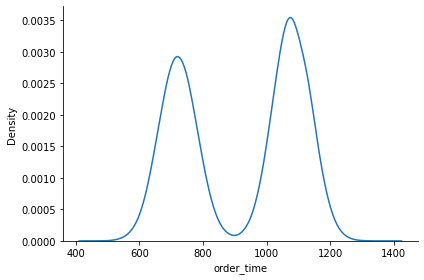

In [8]:
sns.displot(crafted["order_time"], 
            kind="kde",
            bw_adjust=1,
            height=4, aspect=6/4,
            legend=True).savefig("Plots/order_time_dist.png")

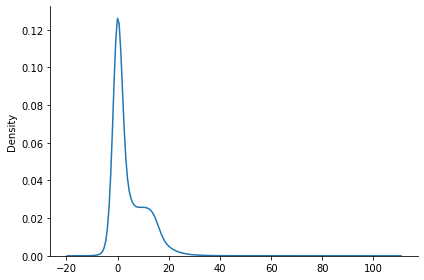

In [15]:
sns.displot(crafted["atd"]-crafted["etd"], 
            kind="kde", 
            bw_adjust=3,
            height=4, aspect=6/4).savefig("Plots/delivery_delay.png")

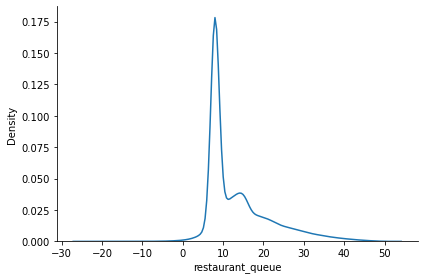

In [10]:
sns.displot(
    crafted["restaurant_queue"],
    kind="kde",
    bw_adjust = 2,
    height = 4, aspect=6/4
).savefig("Plots/prep_time.png")

(23341, 2)


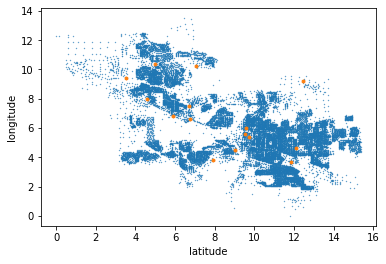

In [16]:
customer_locations = np.asarray(list(set(zip(raw.location_x, raw.location_y))))
customer_locations_x = [t[0] for t in customer_locations]
customer_locations_y = [t[1] for t in customer_locations]

restaurant_locations = list(set(zip(raw.restaurant_location_x, raw.restaurant_location_y)))
restaurant_locations_x = [t[0] for t in restaurant_locations]
restaurant_locations_y = [t[1] for t in restaurant_locations]

print(customer_locations.shape)
plt.scatter(customer_locations_x, customer_locations_y, s=0.1)
plt.scatter(restaurant_locations_x, restaurant_locations_y, s=10, marker="h")
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.savefig("Plots/spatial_dist.png")

plt.show()

# Train() of NN, temporary in this notebook

In [5]:
def train(model, data, feature_list, params):
    
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("Importing data.")

    etd_dataset = ETDData(data=data, feature_list=feature_list, objective=model.name)
    split = DataSplit(etd_dataset, shuffle=True)
    trainloader, _, testloader = split.get_split(batch_size=params["batch_size"], num_workers=8)
    
    print("Start training.")
    patience = params["patience"]
    criterion = params["criterion"]  # define your loss function and optimizer
    optimizer = params["optimizer"]

    
    early_stopping = EarlyStopping(patience=params["patience"], verbose=True) 
    epochs = params["epochs"] # How many epochs do you want to train?
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.float().to(device)
            labels = labels.float().view(-1, model.view).to(device) 
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels) 
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        test_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.float().to(device)
                labels = labels.float().view(-1, model.view).to(device) 
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)
                test_loss += batch_loss.item()
        print(f"Epoch {epoch+1}/{epochs}.. "
                f"Train loss: {running_loss / len(trainloader):.3f}.. "
                f"Test loss: {test_loss / len(testloader):.3f}.. ")
        early_stopping(test_loss / len(testloader), model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        model.train()
        
    print('Finished Training')
    #model.load_state_dict(torch.load('checkpoint.pt'))
    #model.save(ae, 'perceptron.pth')
    return model, abs(early_stopping.best_score)

# Study

## Part 1: Different sample sizes 

With the first part, we seek to examine the convergence behavior of our models and answer following question: How many samples are enough to train the model without ? 
We determine the answer to that question graphically. For that, we construct plots where the x-axis represents the number of samples used in the corresponding training instance, and the y-axis represents the corresponding L<sub>2</sub>-loss measured with the mean squared error.

### Define helper functions ###

In [ ]:
def plot_convergence(sample_sizes, results, title):
    plt.xlabel("Sample size")
    plt.ylabel("Mean squared error")
    plt.plot(sample_sizes, results)
    plt.savefig(f"Plots/{title}.png")

# Helper function for lightgbm
def best_iteration(evals_result):
    iterations = evals_result
    small = iterations[0]
    for i in iterations:
        if small > i:
            small = i
     
    return small    

### Test 1.1: Tree-based ensembles: GBDT and RF (LightGBM Implementation)

In [ ]:
### Convergence Test for LightGBM's GBDT ###
def lightgbm_sample_size_testing(X, y, params, start=1000, stop=200000, step=1000, early_stopping_rounds=10):
    
    sample_sizes = np.arange(start=start, stop=stop, step=step)
    results = []
    
    evals_result = {}
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=42)
    
    for rows in sample_sizes:
        train_set = lgb.Dataset(X_train[:rows],y_train[:rows])
        val_set = lgb.Dataset(X_test, y_test, reference=train_set)
        bst = lgb.train(
            params,
            train_set=train_set,
            valid_sets=[val_set, train_set],
            evals_result = evals_result,
        )
        best_iter = best_iteration(evals_result=dict(evals_result["valid_0"])["l2"])
        results.append(best_iter)
    plot_convergence(sample_sizes, results, "gbdt_convergence")

In [ ]:
params_gbdt = {
    "boosting_type" : "gbdt",
    "metrics" : "l2",
    "learning_rate" : 0.02, 
    "num_threads"  : 6,
    "random_state" : 42,
    "force_row_wise" : True,
    "n_estimators" : 500,
    "early_stopping_rounds" : 20, 
}

lightgbm_sample_size_testing(X, y, params_gbdt, 1000, 101000, 1000)

In [ ]:
params_rf = {
    "boosting_type" : "rf",
    "metrics" : "l2", 
    "num_leaves" : 500,
    "learning_rate" : 0.0001,
    "n_estimators" : 500,
    "bagging_fraction" : 0.632,
    "bagging_freq" : 1,
    "feature_fraction" : 0.632,
    "min_data_in_leaf" : 1,
    "min_data_in_bin" : 1,
    "num_threads"  : 6,
    "random_state" : 42,
    "force_row_wise" : True,
    "early_stopping_rounds" : 20
}

lightgbm_sample_size_testing(X, y, params_gbdt, 1000, 101000, 1000)

### Test 1.2: Linear Regression

In [ ]:
### Convergence test for Scikit-Learn's Linear Regression ###
def lr_sample_size_testing(X, y, params=None, start=1000, stop=100000, step=1000):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=42)
    sample_sizes = np.arange(start=start, stop=stop, step=step)
    results = []
    
    for rows in sample_sizes:
        lr = LinearRegression()
        lr.fit(X_train[:rows], y_train[:rows])
        mse = mean_squared_error(y_test, lr.predict(X_test))
        print(f"Sample size - error : {rows} - {mse}")
        results.append(mse)
    plot_convergence(sample_sizes, results, "LR_Convergence")

lr_sample_size_testing(X, y)

### Test 1.3: Single Layer Perceptron

In [ ]:
sample_sizes = [1000,10000,100000]
results = []

n_features = len(features)
n_hidden = math.ceil(n_features * (1 / 2))
n_code = math.ceil(n_hidden * (1 / 2))

ae = Autoencoder(n_features=n_features, n_hidden=n_hidden, n_code=n_code)
slp = Regressor(n_features = n_features, n_hidden = n_hidden, n_output = 1)

params = {
        "patience" : 10,
        "criterion" : nn.MSELoss(),
        "optimizer" : optim.Adam(slp.parameters(), lr=0.0001),
        "epochs" : 100,
        "batch_size" : 50,
}

for rows in sample_sizes:
    print(f"Sample size {rows}")
    model, mse = train(slp, raw[:rows], features, params)
    results.append(mse)
    print(f"Mean squared error: {mse} for sample size: {rows}")
plot_convergence(sample_sizes, results, "nn_convergence")

## Part 2: Hyperparameter optimization

In [14]:
def gbdt_opt(trial, X, y, boosting_type, sample_size=100000):
    
    sample_size=sample_size
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=42)
    train_set = lgb.Dataset(X_train[:sample_size],y_train[:sample_size])
    valid_set = lgb.Dataset(X_test, y_test)
    
    params = {
        "gbdt" : {
            "boosting_type" : "gbdt",
            "metric" : "l2",
            "objective" : "regression",
            "learning_rate" : trial.suggest_uniform("learning_rate", 0.01, 0.05),
            "num_leaves" : trial.suggest_int("num_leaves", 30, 200),
            "min_data_in_leaf" : trial.suggest_int("min_child_samples", 1, 50),
            "max_bin" : 1000,
            "num_threads"  : 6,
            "random_state" : 42,
            "force_row_wise" : True, 
            "num_boost_round": 1000,
            "early_stopping" : 20
            
        },
        "rf" : {
            
        }      
    }
    evals_result = {}
    bst = lgb.train(
        params[boosting_type],
        train_set=train_set,
        valid_sets=[valid_set, train_set],
        valid_names=["Validation error", "Train error"],
        evals_result = evals_result,
        verbose_eval = 5,
    )
    preds = bst.predict(X_test)
    loss  = mean_squared_error(y_test, preds)
    return loss

In [15]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.CmaEsSampler(seed=42))
study.optimize(lambda trial: gbdt_opt(trial, X, y, "gbdt", 100000), n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("Value: {}".format(trial.value))
print("Params: ")
for key, value in trial.params.items():
    print("{}: {}".format(key, value))   

[I 2021-02-02 20:51:05,324] A new study created in memory with name: no-name-2e5e7b7a-2942-4d28-aae1-65403125cbce


[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 38.133	Validation error's l2: 37.9376
[10]	Train error's l2: 35.8657	Validation error's l2: 35.815
[15]	Train error's l2: 34.0525	Validation error's l2: 34.1232
[20]	Train error's l2: 32.6034	Validation error's l2: 32.7979
[25]	Train error's l2: 31.4149	Validation error's l2: 31.725
[30]	Train error's l2: 30.4349	Validation error's l2: 30.8601
[35]	Train error's l2: 29.6171	Validation error's l2: 30.1638
[40]	Train error's l2: 28.9329	Validation error's l2: 29.5972
[45]	Train error's l2: 28.3489	Validation error's l2: 29.1318
[50]	Train error's l2: 27.8591	Validation error's l2: 28.7565
[55]	Train error's l2: 27.4294	Validation error's l2: 28.436
[60]	Train error's l2: 27.0535	Validation error's l2: 28.1758
[65]	Train error's

[I 2021-02-02 20:51:20,872] Trial 0 finished with value: 26.164621055383076 and parameters: {'learning_rate': 0.0249816047538945, 'num_leaves': 122, 'min_child_samples': 15}. Best is trial 0 with value: 26.164621055383076.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 37.7721	Validation error's l2: 37.5943
[10]	Train error's l2: 35.3169	Validation error's l2: 35.286
[15]	Train error's l2: 33.4098	Validation error's l2: 33.5101
[20]	Train error's l2: 31.9327	Validation error's l2: 32.1607
[25]	Train error's l2: 30.7536	Validation error's l2: 31.1073
[30]	Train error's l2: 29.7897	Validation error's l2: 30.2681
[35]	Train error's l2: 29.004	Validation error's l2: 29.6095
[40]	Train error's l2: 28.3598	Validation error's l2: 29.0887
[45]	Train error's l2: 27.8289	Validation error's l2: 28.6789
[50]	Train error's l2: 27.3675	Validation error's l2: 28.3355
[55]	Train error's l2: 26.9756	Validation error's l2: 28.0599
[60]	Train error's l2: 26.6214	Validation error's l2: 27.8374
[65]	Train error

[I 2021-02-02 20:51:34,314] Trial 1 finished with value: 26.14814418980261 and parameters: {'learning_rate': 0.02874843656877058, 'num_leaves': 115, 'min_child_samples': 25}. Best is trial 1 with value: 26.14814418980261.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 37.6907	Validation error's l2: 37.5189
[10]	Train error's l2: 35.1828	Validation error's l2: 35.1626
[15]	Train error's l2: 33.2642	Validation error's l2: 33.3789
[20]	Train error's l2: 31.7779	Validation error's l2: 32.023
[25]	Train error's l2: 30.5959	Validation error's l2: 30.9606
[30]	Train error's l2: 29.6392	Validation error's l2: 30.1322
[35]	Train error's l2: 28.8626	Validation error's l2: 29.4885
[40]	Train error's l2: 28.2297	Validation error's l2: 28.9807
[45]	Train error's l2: 27.699	Validation error's l2: 28.5764
[50]	Train error's l2: 27.2393	Validation error's l2: 28.2389
[55]	Train error's l2: 26.8576	Validation error's l2: 27.9927
[60]	Train error's l2: 26.5167	Validation error's l2: 27.7844
[65]	Train error

[I 2021-02-02 20:51:47,365] Trial 2 finished with value: 26.124809217112517 and parameters: {'learning_rate': 0.0295808779809538, 'num_leaves': 115, 'min_child_samples': 25}. Best is trial 2 with value: 26.124809217112517.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.8505	Validation error's l2: 36.7276
[10]	Train error's l2: 33.9488	Validation error's l2: 34.0081
[15]	Train error's l2: 31.8871	Validation error's l2: 32.1166
[20]	Train error's l2: 30.37	Validation error's l2: 30.7579
[25]	Train error's l2: 29.227	Validation error's l2: 29.7836
[30]	Train error's l2: 28.3547	Validation error's l2: 29.0749
[35]	Train error's l2: 27.6414	Validation error's l2: 28.5134
[40]	Train error's l2: 27.0916	Validation error's l2: 28.1316
[45]	Train error's l2: 26.6167	Validation error's l2: 27.834
[50]	Train error's l2: 26.2119	Validation error's l2: 27.5921
[55]	Train error's l2: 25.8522	Validation error's l2: 27.3834
[60]	Train error's l2: 25.514	Validation error's l2: 27.1918
[65]	Train error's 

[I 2021-02-02 20:51:57,413] Trial 3 finished with value: 26.156815934484758 and parameters: {'learning_rate': 0.03847008112950606, 'num_leaves': 115, 'min_child_samples': 26}. Best is trial 2 with value: 26.124809217112517.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.7161	Validation error's l2: 39.4361
[10]	Train error's l2: 38.5581	Validation error's l2: 38.3365
[15]	Train error's l2: 37.5075	Validation error's l2: 37.3453
[20]	Train error's l2: 36.5591	Validation error's l2: 36.4544
[25]	Train error's l2: 35.6956	Validation error's l2: 35.6427
[30]	Train error's l2: 34.908	Validation error's l2: 34.9042
[35]	Train error's l2: 34.1939	Validation error's l2: 34.2386
[40]	Train error's l2: 33.5424	Validation error's l2: 33.6342
[45]	Train error's l2: 32.9509	Validation error's l2: 33.0893
[50]	Train error's l2: 32.4052	Validation error's l2: 32.5908
[55]	Train error's l2: 31.9034	Validation error's l2: 32.1328
[60]	Train error's l2: 31.4476	Validation error's l2: 31.721
[65]	Train error

[640]	Train error's l2: 21.5406	Validation error's l2: 26.1774
[645]	Train error's l2: 21.5113	Validation error's l2: 26.1762
[650]	Train error's l2: 21.4821	Validation error's l2: 26.175
[655]	Train error's l2: 21.4519	Validation error's l2: 26.1721
[660]	Train error's l2: 21.4219	Validation error's l2: 26.1704
[665]	Train error's l2: 21.3921	Validation error's l2: 26.1683
[670]	Train error's l2: 21.3618	Validation error's l2: 26.1665
[675]	Train error's l2: 21.3328	Validation error's l2: 26.1653
[680]	Train error's l2: 21.3029	Validation error's l2: 26.1628
[685]	Train error's l2: 21.2751	Validation error's l2: 26.1617
[690]	Train error's l2: 21.2474	Validation error's l2: 26.1606
[695]	Train error's l2: 21.2184	Validation error's l2: 26.1596
[700]	Train error's l2: 21.1899	Validation error's l2: 26.1579
[705]	Train error's l2: 21.1632	Validation error's l2: 26.1572
[710]	Train error's l2: 21.1374	Validation error's l2: 26.1568
[715]	Train error's l2: 21.1091	Validation error's l2: 2

[I 2021-02-02 20:52:28,370] Trial 4 finished with value: 26.132940753179078 and parameters: {'learning_rate': 0.010589780672134952, 'num_leaves': 115, 'min_child_samples': 26}. Best is trial 2 with value: 26.124809217112517.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 37.0892	Validation error's l2: 36.9498
[10]	Train error's l2: 34.2985	Validation error's l2: 34.3333
[15]	Train error's l2: 32.2625	Validation error's l2: 32.4625
[20]	Train error's l2: 30.7343	Validation error's l2: 31.0822
[25]	Train error's l2: 29.5732	Validation error's l2: 30.0736
[30]	Train error's l2: 28.66	Validation error's l2: 29.3122
[35]	Train error's l2: 27.9433	Validation error's l2: 28.7444
[40]	Train error's l2: 27.364	Validation error's l2: 28.318
[45]	Train error's l2: 26.8807	Validation error's l2: 27.998
[50]	Train error's l2: 26.467	Validation error's l2: 27.7486
[55]	Train error's l2: 26.0977	Validation error's l2: 27.5367
[60]	Train error's l2: 25.765	Validation error's l2: 27.3444
[65]	Train error's l2

[I 2021-02-02 20:52:38,548] Trial 5 finished with value: 26.17013486897671 and parameters: {'learning_rate': 0.03587482491014493, 'num_leaves': 115, 'min_child_samples': 25}. Best is trial 2 with value: 26.124809217112517.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.949	Validation error's l2: 36.8204
[10]	Train error's l2: 34.0948	Validation error's l2: 34.1435
[15]	Train error's l2: 32.0422	Validation error's l2: 32.2567
[20]	Train error's l2: 30.5249	Validation error's l2: 30.8942
[25]	Train error's l2: 29.362	Validation error's l2: 29.8941
[30]	Train error's l2: 28.4773	Validation error's l2: 29.1659
[35]	Train error's l2: 27.7755	Validation error's l2: 28.6247
[40]	Train error's l2: 27.2079	Validation error's l2: 28.2214
[45]	Train error's l2: 26.7183	Validation error's l2: 27.8965
[50]	Train error's l2: 26.3186	Validation error's l2: 27.6593
[55]	Train error's l2: 25.9412	Validation error's l2: 27.4337
[60]	Train error's l2: 25.6047	Validation error's l2: 27.2442
[65]	Train error

[I 2021-02-02 20:52:49,836] Trial 6 finished with value: 26.16635302250104 and parameters: {'learning_rate': 0.037386022390420326, 'num_leaves': 115, 'min_child_samples': 25}. Best is trial 2 with value: 26.124809217112517.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 37.0921	Validation error's l2: 36.9526
[10]	Train error's l2: 34.3017	Validation error's l2: 34.3356
[15]	Train error's l2: 32.277	Validation error's l2: 32.4683
[20]	Train error's l2: 30.7481	Validation error's l2: 31.0916
[25]	Train error's l2: 29.5782	Validation error's l2: 30.0807
[30]	Train error's l2: 28.6731	Validation error's l2: 29.331
[35]	Train error's l2: 27.9534	Validation error's l2: 28.76
[40]	Train error's l2: 27.375	Validation error's l2: 28.3344
[45]	Train error's l2: 26.8881	Validation error's l2: 28.0054
[50]	Train error's l2: 26.478	Validation error's l2: 27.7578
[55]	Train error's l2: 26.1132	Validation error's l2: 27.5504
[60]	Train error's l2: 25.773	Validation error's l2: 27.3484
[65]	Train error's l2

[I 2021-02-02 20:52:59,493] Trial 7 finished with value: 26.16150883264437 and parameters: {'learning_rate': 0.03584358943257671, 'num_leaves': 115, 'min_child_samples': 25}. Best is trial 2 with value: 26.124809217112517.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.9076	Validation error's l2: 35.8162
[10]	Train error's l2: 32.7214	Validation error's l2: 32.8407
[15]	Train error's l2: 30.5995	Validation error's l2: 30.9093
[20]	Train error's l2: 29.1629	Validation error's l2: 29.6706
[25]	Train error's l2: 28.1525	Validation error's l2: 28.8479
[30]	Train error's l2: 27.3723	Validation error's l2: 28.252
[35]	Train error's l2: 26.778	Validation error's l2: 27.8608
[40]	Train error's l2: 26.2975	Validation error's l2: 27.551
[45]	Train error's l2: 25.872	Validation error's l2: 27.3044
[50]	Train error's l2: 25.512	Validation error's l2: 27.1095
[55]	Train error's l2: 25.1842	Validation error's l2: 26.9544
[60]	Train error's l2: 24.8929	Validation error's l2: 26.8343
[65]	Train error's 

[I 2021-02-02 20:53:07,690] Trial 8 finished with value: 26.15604483461914 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 106, 'min_child_samples': 50}. Best is trial 2 with value: 26.124809217112517.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37597
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 97
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.7721	Validation error's l2: 39.4939
[10]	Train error's l2: 38.6597	Validation error's l2: 38.4424
[15]	Train error's l2: 37.6439	Validation error's l2: 37.4886
[20]	Train error's l2: 36.7199	Validation error's l2: 36.625
[25]	Train error's l2: 35.8729	Validation error's l2: 35.8372
[30]	Train error's l2: 35.1004	Validation error's l2: 35.1202
[35]	Train error's l2: 34.3887	Validation error's l2: 34.4641
[40]	Train error's l2: 33.7394	Validation error's l2: 33.8654
[45]	Train error's l2: 33.1432	Validation error's l2: 33.3206
[50]	Train error's l2: 32.6017	Validation error's l2: 32.8326
[55]	Train error's l2: 32.0983	Validation error's l2: 32.3818
[60]	Train error's l2: 31.6339	Validation error's l2: 31.9647
[65]	Train erro

[640]	Train error's l2: 21.1045	Validation error's l2: 26.2163
[645]	Train error's l2: 21.07	Validation error's l2: 26.2138
[650]	Train error's l2: 21.0363	Validation error's l2: 26.2102
[655]	Train error's l2: 21.0048	Validation error's l2: 26.2082
[660]	Train error's l2: 20.9723	Validation error's l2: 26.2068
[665]	Train error's l2: 20.9432	Validation error's l2: 26.2062
[670]	Train error's l2: 20.9125	Validation error's l2: 26.2049
[675]	Train error's l2: 20.8808	Validation error's l2: 26.2033
[680]	Train error's l2: 20.8489	Validation error's l2: 26.2008
[685]	Train error's l2: 20.8198	Validation error's l2: 26.1997
[690]	Train error's l2: 20.7895	Validation error's l2: 26.198
[695]	Train error's l2: 20.7597	Validation error's l2: 26.196
[700]	Train error's l2: 20.73	Validation error's l2: 26.1948
[705]	Train error's l2: 20.7012	Validation error's l2: 26.1937
[710]	Train error's l2: 20.675	Validation error's l2: 26.1934
[715]	Train error's l2: 20.6458	Validation error's l2: 26.1917

[I 2021-02-02 20:53:46,163] Trial 9 finished with value: 26.155642169628763 and parameters: {'learning_rate': 0.01, 'num_leaves': 123, 'min_child_samples': 8}. Best is trial 2 with value: 26.124809217112517.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.8641	Validation error's l2: 35.7836
[10]	Train error's l2: 32.6589	Validation error's l2: 32.8026
[15]	Train error's l2: 30.5237	Validation error's l2: 30.8677
[20]	Train error's l2: 29.0666	Validation error's l2: 29.6209
[25]	Train error's l2: 28.0355	Validation error's l2: 28.7932
[30]	Train error's l2: 27.2631	Validation error's l2: 28.219
[35]	Train error's l2: 26.666	Validation error's l2: 27.8355
[40]	Train error's l2: 26.1666	Validation error's l2: 27.5324
[45]	Train error's l2: 25.7228	Validation error's l2: 27.2713
[50]	Train error's l2: 25.349	Validation error's l2: 27.0767
[55]	Train error's l2: 25.0265	Validation error's l2: 26.9367
[60]	Train error's l2: 24.7171	Validation error's l2: 26.8151
[65]	Train error'

[I 2021-02-02 20:53:54,653] Trial 10 finished with value: 26.1837309503477 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 114, 'min_child_samples': 50}. Best is trial 2 with value: 26.124809217112517.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.7979	Validation error's l2: 39.511
[10]	Train error's l2: 38.7075	Validation error's l2: 38.4711
[15]	Train error's l2: 37.713	Validation error's l2: 37.5268
[20]	Train error's l2: 36.8077	Validation error's l2: 36.6711
[25]	Train error's l2: 35.9819	Validation error's l2: 35.8917
[30]	Train error's l2: 35.2268	Validation error's l2: 35.1801
[35]	Train error's l2: 34.5316	Validation error's l2: 34.5268
[40]	Train error's l2: 33.8999	Validation error's l2: 33.9363
[45]	Train error's l2: 33.3262	Validation error's l2: 33.4034
[50]	Train error's l2: 32.7941	Validation error's l2: 32.9113
[55]	Train error's l2: 32.302	Validation error's l2: 32.4576
[60]	Train error's l2: 31.8433	Validation error's l2: 32.0375
[65]	Train error'

[640]	Train error's l2: 22.2907	Validation error's l2: 26.2041
[645]	Train error's l2: 22.263	Validation error's l2: 26.2007
[650]	Train error's l2: 22.2353	Validation error's l2: 26.1978
[655]	Train error's l2: 22.207	Validation error's l2: 26.1944
[660]	Train error's l2: 22.1799	Validation error's l2: 26.1915
[665]	Train error's l2: 22.1532	Validation error's l2: 26.1896
[670]	Train error's l2: 22.1258	Validation error's l2: 26.1881
[675]	Train error's l2: 22.0988	Validation error's l2: 26.1854
[680]	Train error's l2: 22.0723	Validation error's l2: 26.1817
[685]	Train error's l2: 22.0457	Validation error's l2: 26.1798
[690]	Train error's l2: 22.0212	Validation error's l2: 26.1778
[695]	Train error's l2: 21.9962	Validation error's l2: 26.1762
[700]	Train error's l2: 21.9695	Validation error's l2: 26.1744
[705]	Train error's l2: 21.9448	Validation error's l2: 26.1731
[710]	Train error's l2: 21.9202	Validation error's l2: 26.1711
[715]	Train error's l2: 21.8945	Validation error's l2: 26

[I 2021-02-02 20:54:30,258] Trial 11 finished with value: 26.11199149225126 and parameters: {'learning_rate': 0.01, 'num_leaves': 107, 'min_child_samples': 50}. Best is trial 11 with value: 26.11199149225126.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.8326	Validation error's l2: 35.7674
[10]	Train error's l2: 32.6024	Validation error's l2: 32.7649
[15]	Train error's l2: 30.4494	Validation error's l2: 30.844
[20]	Train error's l2: 28.9639	Validation error's l2: 29.5694
[25]	Train error's l2: 27.9078	Validation error's l2: 28.7326
[30]	Train error's l2: 27.1279	Validation error's l2: 28.1583
[35]	Train error's l2: 26.5059	Validation error's l2: 27.7592
[40]	Train error's l2: 25.9979	Validation error's l2: 27.4816
[45]	Train error's l2: 25.5519	Validation error's l2: 27.2325
[50]	Train error's l2: 25.1721	Validation error's l2: 27.0492
[55]	Train error's l2: 24.8359	Validation error's l2: 26.9133
[60]	Train error's l2: 24.5209	Validation error's l2: 26.7935
[65]	Train erro

[I 2021-02-02 20:54:39,144] Trial 12 finished with value: 26.160844040583374 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 120, 'min_child_samples': 38}. Best is trial 11 with value: 26.11199149225126.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.8559	Validation error's l2: 35.7772
[10]	Train error's l2: 32.6344	Validation error's l2: 32.7813
[15]	Train error's l2: 30.4985	Validation error's l2: 30.8528
[20]	Train error's l2: 29.0371	Validation error's l2: 29.6043
[25]	Train error's l2: 27.9988	Validation error's l2: 28.7711
[30]	Train error's l2: 27.231	Validation error's l2: 28.207
[35]	Train error's l2: 26.6303	Validation error's l2: 27.8277
[40]	Train error's l2: 26.14	Validation error's l2: 27.5475
[45]	Train error's l2: 25.7011	Validation error's l2: 27.2928
[50]	Train error's l2: 25.3265	Validation error's l2: 27.1009
[55]	Train error's l2: 25.0009	Validation error's l2: 26.9547
[60]	Train error's l2: 24.6853	Validation error's l2: 26.8113
[65]	Train error's

[I 2021-02-02 20:54:48,068] Trial 13 finished with value: 26.17042267031749 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 115, 'min_child_samples': 50}. Best is trial 11 with value: 26.11199149225126.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.8052	Validation error's l2: 39.5167
[10]	Train error's l2: 38.7217	Validation error's l2: 38.4826
[15]	Train error's l2: 37.7328	Validation error's l2: 37.5422
[20]	Train error's l2: 36.833	Validation error's l2: 36.6909
[25]	Train error's l2: 36.0137	Validation error's l2: 35.9145
[30]	Train error's l2: 35.2642	Validation error's l2: 35.2064
[35]	Train error's l2: 34.5748	Validation error's l2: 34.5575
[40]	Train error's l2: 33.9511	Validation error's l2: 33.9719
[45]	Train error's l2: 33.3794	Validation error's l2: 33.4405
[50]	Train error's l2: 32.8494	Validation error's l2: 32.9488
[55]	Train error's l2: 32.3576	Validation error's l2: 32.4939
[60]	Train error's l2: 31.9045	Validation error's l2: 32.0773
[65]	Train erro

[645]	Train error's l2: 22.4715	Validation error's l2: 26.2094
[650]	Train error's l2: 22.4445	Validation error's l2: 26.206
[655]	Train error's l2: 22.4187	Validation error's l2: 26.2038
[660]	Train error's l2: 22.3925	Validation error's l2: 26.2008
[665]	Train error's l2: 22.366	Validation error's l2: 26.1992
[670]	Train error's l2: 22.3398	Validation error's l2: 26.1961
[675]	Train error's l2: 22.3146	Validation error's l2: 26.1943
[680]	Train error's l2: 22.2889	Validation error's l2: 26.1914
[685]	Train error's l2: 22.265	Validation error's l2: 26.1896
[690]	Train error's l2: 22.24	Validation error's l2: 26.1877
[695]	Train error's l2: 22.2144	Validation error's l2: 26.1848
[700]	Train error's l2: 22.1899	Validation error's l2: 26.1827
[705]	Train error's l2: 22.1645	Validation error's l2: 26.1801
[710]	Train error's l2: 22.1419	Validation error's l2: 26.1783
[715]	Train error's l2: 22.1175	Validation error's l2: 26.1756
[720]	Train error's l2: 22.0946	Validation error's l2: 26.17

[I 2021-02-02 20:55:20,997] Trial 14 finished with value: 26.115688005898193 and parameters: {'learning_rate': 0.01, 'num_leaves': 101, 'min_child_samples': 50}. Best is trial 11 with value: 26.11199149225126.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9615	Validation error's l2: 39.6485
[10]	Train error's l2: 39.0271	Validation error's l2: 38.7396
[15]	Train error's l2: 38.1743	Validation error's l2: 37.9115
[20]	Train error's l2: 37.398	Validation error's l2: 37.1597
[25]	Train error's l2: 36.6907	Validation error's l2: 36.4776
[30]	Train error's l2: 36.044	Validation error's l2: 35.8555
[35]	Train error's l2: 35.454	Validation error's l2: 35.2898
[40]	Train error's l2: 34.9125	Validation error's l2: 34.7716
[45]	Train error's l2: 34.4132	Validation error's l2: 34.2973
[50]	Train error's l2: 33.9541	Validation error's l2: 33.8602
[55]	Train error's l2: 33.5265	Validation error's l2: 33.4546
[60]	Train error's l2: 33.1181	Validation error's l2: 33.0667
[65]	Train error

[645]	Train error's l2: 25.3092	Validation error's l2: 26.8585
[650]	Train error's l2: 25.2917	Validation error's l2: 26.8514
[655]	Train error's l2: 25.2746	Validation error's l2: 26.846
[660]	Train error's l2: 25.2588	Validation error's l2: 26.8418
[665]	Train error's l2: 25.2419	Validation error's l2: 26.8365
[670]	Train error's l2: 25.2252	Validation error's l2: 26.8304
[675]	Train error's l2: 25.2088	Validation error's l2: 26.8252
[680]	Train error's l2: 25.1907	Validation error's l2: 26.817
[685]	Train error's l2: 25.1745	Validation error's l2: 26.8128
[690]	Train error's l2: 25.1564	Validation error's l2: 26.8061
[695]	Train error's l2: 25.1409	Validation error's l2: 26.8013
[700]	Train error's l2: 25.1239	Validation error's l2: 26.7963
[705]	Train error's l2: 25.108	Validation error's l2: 26.7911
[710]	Train error's l2: 25.0914	Validation error's l2: 26.7837
[715]	Train error's l2: 25.0757	Validation error's l2: 26.7795
[720]	Train error's l2: 25.06	Validation error's l2: 26.77

[I 2021-02-02 20:55:39,246] Trial 15 finished with value: 26.606154725046302 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 11 with value: 26.11199149225126.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9663	Validation error's l2: 39.6504
[10]	Train error's l2: 39.0328	Validation error's l2: 38.7406
[15]	Train error's l2: 38.184	Validation error's l2: 37.9151
[20]	Train error's l2: 37.4112	Validation error's l2: 37.164
[25]	Train error's l2: 36.7039	Validation error's l2: 36.477
[30]	Train error's l2: 36.0597	Validation error's l2: 35.8529
[35]	Train error's l2: 35.4698	Validation error's l2: 35.2842
[40]	Train error's l2: 34.9323	Validation error's l2: 34.766
[45]	Train error's l2: 34.4414	Validation error's l2: 34.2928
[50]	Train error's l2: 33.9856	Validation error's l2: 33.8564
[55]	Train error's l2: 33.5534	Validation error's l2: 33.443
[60]	Train error's l2: 33.1565	Validation error's l2: 33.0653
[65]	Train error's 

[645]	Train error's l2: 25.6431	Validation error's l2: 26.7634
[650]	Train error's l2: 25.628	Validation error's l2: 26.7579
[655]	Train error's l2: 25.6135	Validation error's l2: 26.753
[660]	Train error's l2: 25.5969	Validation error's l2: 26.7438
[665]	Train error's l2: 25.5815	Validation error's l2: 26.737
[670]	Train error's l2: 25.565	Validation error's l2: 26.728
[675]	Train error's l2: 25.5513	Validation error's l2: 26.724
[680]	Train error's l2: 25.537	Validation error's l2: 26.7177
[685]	Train error's l2: 25.5215	Validation error's l2: 26.71
[690]	Train error's l2: 25.5056	Validation error's l2: 26.7034
[695]	Train error's l2: 25.4898	Validation error's l2: 26.6951
[700]	Train error's l2: 25.4762	Validation error's l2: 26.6898
[705]	Train error's l2: 25.4613	Validation error's l2: 26.6846
[710]	Train error's l2: 25.4471	Validation error's l2: 26.6783
[715]	Train error's l2: 25.4334	Validation error's l2: 26.6721
[720]	Train error's l2: 25.4193	Validation error's l2: 26.6671
[

[I 2021-02-02 20:55:58,286] Trial 16 finished with value: 26.471672982398687 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 50}. Best is trial 11 with value: 26.11199149225126.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.7163	Validation error's l2: 39.4567
[10]	Train error's l2: 38.5526	Validation error's l2: 38.3711
[15]	Train error's l2: 37.494	Validation error's l2: 37.3904
[20]	Train error's l2: 36.5231	Validation error's l2: 36.4983
[25]	Train error's l2: 35.6332	Validation error's l2: 35.6854
[30]	Train error's l2: 34.8203	Validation error's l2: 34.9491
[35]	Train error's l2: 34.0796	Validation error's l2: 34.2825
[40]	Train error's l2: 33.3953	Validation error's l2: 33.6718
[45]	Train error's l2: 32.7654	Validation error's l2: 33.1111
[50]	Train error's l2: 32.1893	Validation error's l2: 32.6032
[55]	Train error's l2: 31.658	Validation error's l2: 32.1402
[60]	Train error's l2: 31.1663	Validation error's l2: 31.7167
[65]	Train error

[640]	Train error's l2: 19.6006	Validation error's l2: 26.1465
[645]	Train error's l2: 19.5648	Validation error's l2: 26.1466
[650]	Train error's l2: 19.5273	Validation error's l2: 26.1451
[655]	Train error's l2: 19.4909	Validation error's l2: 26.1435
[660]	Train error's l2: 19.4539	Validation error's l2: 26.142
[665]	Train error's l2: 19.418	Validation error's l2: 26.1405
[670]	Train error's l2: 19.3816	Validation error's l2: 26.1397
[675]	Train error's l2: 19.3451	Validation error's l2: 26.1385
[680]	Train error's l2: 19.3091	Validation error's l2: 26.1377
[685]	Train error's l2: 19.2722	Validation error's l2: 26.1366
[690]	Train error's l2: 19.2358	Validation error's l2: 26.1359
[695]	Train error's l2: 19.1997	Validation error's l2: 26.1352
[700]	Train error's l2: 19.1662	Validation error's l2: 26.1344
[705]	Train error's l2: 19.1311	Validation error's l2: 26.134
[710]	Train error's l2: 19.0954	Validation error's l2: 26.1339
[715]	Train error's l2: 19.0599	Validation error's l2: 26.

[I 2021-02-02 20:56:42,897] Trial 17 finished with value: 26.122397405621935 and parameters: {'learning_rate': 0.01, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 11 with value: 26.11199149225126.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.7904	Validation error's l2: 39.5048
[10]	Train error's l2: 38.6937	Validation error's l2: 38.4603
[15]	Train error's l2: 37.6926	Validation error's l2: 37.511
[20]	Train error's l2: 36.7817	Validation error's l2: 36.6528
[25]	Train error's l2: 35.9516	Validation error's l2: 35.8723
[30]	Train error's l2: 35.1914	Validation error's l2: 35.1581
[35]	Train error's l2: 34.4912	Validation error's l2: 34.5013
[40]	Train error's l2: 33.8567	Validation error's l2: 33.9104
[45]	Train error's l2: 33.2754	Validation error's l2: 33.3707
[50]	Train error's l2: 32.7396	Validation error's l2: 32.8773
[55]	Train error's l2: 32.2445	Validation error's l2: 32.4222
[60]	Train error's l2: 31.7889	Validation error's l2: 32.0065
[65]	Train erro

[650]	Train error's l2: 22.0247	Validation error's l2: 26.1819
[655]	Train error's l2: 21.9975	Validation error's l2: 26.1804
[660]	Train error's l2: 21.9706	Validation error's l2: 26.1789
[665]	Train error's l2: 21.9432	Validation error's l2: 26.176
[670]	Train error's l2: 21.9155	Validation error's l2: 26.173
[675]	Train error's l2: 21.8871	Validation error's l2: 26.1709
[680]	Train error's l2: 21.8592	Validation error's l2: 26.1679
[685]	Train error's l2: 21.832	Validation error's l2: 26.1653
[690]	Train error's l2: 21.8052	Validation error's l2: 26.1635
[695]	Train error's l2: 21.7788	Validation error's l2: 26.162
[700]	Train error's l2: 21.7514	Validation error's l2: 26.1605
[705]	Train error's l2: 21.7237	Validation error's l2: 26.157
[710]	Train error's l2: 21.6973	Validation error's l2: 26.1557
[715]	Train error's l2: 21.6716	Validation error's l2: 26.1541
[720]	Train error's l2: 21.6465	Validation error's l2: 26.1526
[725]	Train error's l2: 21.6203	Validation error's l2: 26.15

[I 2021-02-02 20:57:16,714] Trial 18 finished with value: 26.1044868897269 and parameters: {'learning_rate': 0.01, 'num_leaves': 113, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6239	Validation error's l2: 36.4149
[10]	Train error's l2: 33.8858	Validation error's l2: 33.7921
[15]	Train error's l2: 32.0272	Validation error's l2: 32.0363
[20]	Train error's l2: 30.7602	Validation error's l2: 30.864
[25]	Train error's l2: 29.8723	Validation error's l2: 30.0586
[30]	Train error's l2: 29.2351	Validation error's l2: 29.4965
[35]	Train error's l2: 28.7097	Validation error's l2: 29.0535
[40]	Train error's l2: 28.2926	Validation error's l2: 28.7012
[45]	Train error's l2: 27.941	Validation error's l2: 28.4295
[50]	Train error's l2: 27.6143	Validation error's l2: 28.1738
[55]	Train error's l2: 27.3597	Validation error's l2: 27.989
[60]	Train error's l2: 27.1177	Validation error's l2: 27.8086
[65]	Train error

[I 2021-02-02 20:57:25,203] Trial 19 finished with value: 26.39862954206284 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.6988	Validation error's l2: 39.4718
[10]	Train error's l2: 38.5166	Validation error's l2: 38.3971
[15]	Train error's l2: 37.4415	Validation error's l2: 37.4257
[20]	Train error's l2: 36.4613	Validation error's l2: 36.5489
[25]	Train error's l2: 35.5619	Validation error's l2: 35.7475
[30]	Train error's l2: 34.7403	Validation error's l2: 35.0239
[35]	Train error's l2: 33.981	Validation error's l2: 34.3585
[40]	Train error's l2: 33.2856	Validation error's l2: 33.7493
[45]	Train error's l2: 32.6488	Validation error's l2: 33.2018
[50]	Train error's l2: 32.0633	Validation error's l2: 32.7025
[55]	Train error's l2: 31.5206	Validation error's l2: 32.2469
[60]	Train error's l2: 31.0196	Validation error's l2: 31.8275
[65]	Train err

[645]	Train error's l2: 19.0613	Validation error's l2: 26.241
[650]	Train error's l2: 19.0197	Validation error's l2: 26.2388
[655]	Train error's l2: 18.9821	Validation error's l2: 26.2375
[660]	Train error's l2: 18.9443	Validation error's l2: 26.2355
[665]	Train error's l2: 18.9091	Validation error's l2: 26.2353
[670]	Train error's l2: 18.8726	Validation error's l2: 26.2351
[675]	Train error's l2: 18.8363	Validation error's l2: 26.2342
[680]	Train error's l2: 18.797	Validation error's l2: 26.234
[685]	Train error's l2: 18.7637	Validation error's l2: 26.233
[690]	Train error's l2: 18.7256	Validation error's l2: 26.2314
[695]	Train error's l2: 18.6913	Validation error's l2: 26.2306
[700]	Train error's l2: 18.6556	Validation error's l2: 26.2288
[705]	Train error's l2: 18.6191	Validation error's l2: 26.2277
[710]	Train error's l2: 18.5862	Validation error's l2: 26.2277
[715]	Train error's l2: 18.5528	Validation error's l2: 26.2282
[720]	Train error's l2: 18.5199	Validation error's l2: 26.2

[I 2021-02-02 20:58:00,082] Trial 20 finished with value: 26.227676868824016 and parameters: {'learning_rate': 0.01, 'num_leaves': 175, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.5535	Validation error's l2: 35.6051
[10]	Train error's l2: 32.1114	Validation error's l2: 32.5343
[15]	Train error's l2: 29.8037	Validation error's l2: 30.5723
[20]	Train error's l2: 28.214	Validation error's l2: 29.3322
[25]	Train error's l2: 27.0465	Validation error's l2: 28.4814
[30]	Train error's l2: 26.1613	Validation error's l2: 27.917
[35]	Train error's l2: 25.4623	Validation error's l2: 27.5316
[40]	Train error's l2: 24.8743	Validation error's l2: 27.266
[45]	Train error's l2: 24.3407	Validation error's l2: 27.039
[50]	Train error's l2: 23.8803	Validation error's l2: 26.8728
[55]	Train error's l2: 23.4683	Validation error's l2: 26.7452
[60]	Train error's l2: 23.1019	Validation error's l2: 26.6454
[65]	Train error's

[I 2021-02-02 20:58:08,803] Trial 21 finished with value: 26.20061750752377 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6239	Validation error's l2: 36.4149
[10]	Train error's l2: 33.8858	Validation error's l2: 33.7921
[15]	Train error's l2: 32.0272	Validation error's l2: 32.0363
[20]	Train error's l2: 30.7602	Validation error's l2: 30.864
[25]	Train error's l2: 29.8723	Validation error's l2: 30.0586
[30]	Train error's l2: 29.2351	Validation error's l2: 29.4965
[35]	Train error's l2: 28.7097	Validation error's l2: 29.0535
[40]	Train error's l2: 28.2926	Validation error's l2: 28.7012
[45]	Train error's l2: 27.941	Validation error's l2: 28.4295
[50]	Train error's l2: 27.6143	Validation error's l2: 28.1738
[55]	Train error's l2: 27.3597	Validation error's l2: 27.989
[60]	Train error's l2: 27.1177	Validation error's l2: 27.8086
[65]	Train error

[I 2021-02-02 20:58:17,108] Trial 22 finished with value: 26.39862954206284 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.6755	Validation error's l2: 39.4631
[10]	Train error's l2: 38.474	Validation error's l2: 38.3815
[15]	Train error's l2: 37.3807	Validation error's l2: 37.4035
[20]	Train error's l2: 36.383	Validation error's l2: 36.516
[25]	Train error's l2: 35.4645	Validation error's l2: 35.7111
[30]	Train error's l2: 34.6231	Validation error's l2: 34.9786
[35]	Train error's l2: 33.852	Validation error's l2: 34.3133
[40]	Train error's l2: 33.1408	Validation error's l2: 33.7007
[45]	Train error's l2: 32.4908	Validation error's l2: 33.1509
[50]	Train error's l2: 31.8901	Validation error's l2: 32.6517
[55]	Train error's l2: 31.336	Validation error's l2: 32.1911
[60]	Train error's l2: 30.8231	Validation error's l2: 31.7719
[65]	Train error's

[650]	Train error's l2: 18.2795	Validation error's l2: 26.2529
[655]	Train error's l2: 18.2415	Validation error's l2: 26.2517
[660]	Train error's l2: 18.2004	Validation error's l2: 26.2504
[665]	Train error's l2: 18.1612	Validation error's l2: 26.2498
[670]	Train error's l2: 18.1254	Validation error's l2: 26.2498
[675]	Train error's l2: 18.0859	Validation error's l2: 26.2497
[680]	Train error's l2: 18.0469	Validation error's l2: 26.2495
[685]	Train error's l2: 18.0114	Validation error's l2: 26.2492
[690]	Train error's l2: 17.9741	Validation error's l2: 26.2492
[695]	Train error's l2: 17.9368	Validation error's l2: 26.2477
[700]	Train error's l2: 17.8997	Validation error's l2: 26.2473
[705]	Train error's l2: 17.8627	Validation error's l2: 26.2465
[710]	Train error's l2: 17.8271	Validation error's l2: 26.2455
[715]	Train error's l2: 17.791	Validation error's l2: 26.2447
[720]	Train error's l2: 17.7523	Validation error's l2: 26.2443
[725]	Train error's l2: 17.715	Validation error's l2: 26

[I 2021-02-02 20:59:00,700] Trial 23 finished with value: 26.232973666058957 and parameters: {'learning_rate': 0.01, 'num_leaves': 200, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.6755	Validation error's l2: 39.4631
[10]	Train error's l2: 38.474	Validation error's l2: 38.3815
[15]	Train error's l2: 37.3807	Validation error's l2: 37.4035
[20]	Train error's l2: 36.383	Validation error's l2: 36.516
[25]	Train error's l2: 35.4645	Validation error's l2: 35.7111
[30]	Train error's l2: 34.6231	Validation error's l2: 34.9786
[35]	Train error's l2: 33.852	Validation error's l2: 34.3133
[40]	Train error's l2: 33.1408	Validation error's l2: 33.7007
[45]	Train error's l2: 32.4908	Validation error's l2: 33.1509
[50]	Train error's l2: 31.8901	Validation error's l2: 32.6517
[55]	Train error's l2: 31.336	Validation error's l2: 32.1911
[60]	Train error's l2: 30.8231	Validation error's l2: 31.7719
[65]	Train error's

[650]	Train error's l2: 18.2795	Validation error's l2: 26.2529
[655]	Train error's l2: 18.2415	Validation error's l2: 26.2517
[660]	Train error's l2: 18.2004	Validation error's l2: 26.2504
[665]	Train error's l2: 18.1612	Validation error's l2: 26.2498
[670]	Train error's l2: 18.1254	Validation error's l2: 26.2498
[675]	Train error's l2: 18.0859	Validation error's l2: 26.2497
[680]	Train error's l2: 18.0469	Validation error's l2: 26.2495
[685]	Train error's l2: 18.0114	Validation error's l2: 26.2492
[690]	Train error's l2: 17.9741	Validation error's l2: 26.2492
[695]	Train error's l2: 17.9368	Validation error's l2: 26.2477
[700]	Train error's l2: 17.8997	Validation error's l2: 26.2473
[705]	Train error's l2: 17.8627	Validation error's l2: 26.2465
[710]	Train error's l2: 17.8271	Validation error's l2: 26.2455
[715]	Train error's l2: 17.791	Validation error's l2: 26.2447
[720]	Train error's l2: 17.7523	Validation error's l2: 26.2443
[725]	Train error's l2: 17.715	Validation error's l2: 26

[I 2021-02-02 20:59:45,177] Trial 24 finished with value: 26.232973666058957 and parameters: {'learning_rate': 0.01, 'num_leaves': 200, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9615	Validation error's l2: 39.6485
[10]	Train error's l2: 39.0271	Validation error's l2: 38.7396
[15]	Train error's l2: 38.1743	Validation error's l2: 37.9115
[20]	Train error's l2: 37.398	Validation error's l2: 37.1597
[25]	Train error's l2: 36.6907	Validation error's l2: 36.4776
[30]	Train error's l2: 36.044	Validation error's l2: 35.8555
[35]	Train error's l2: 35.454	Validation error's l2: 35.2898
[40]	Train error's l2: 34.9125	Validation error's l2: 34.7716
[45]	Train error's l2: 34.4132	Validation error's l2: 34.2973
[50]	Train error's l2: 33.9541	Validation error's l2: 33.8602
[55]	Train error's l2: 33.5265	Validation error's l2: 33.4546
[60]	Train error's l2: 33.1181	Validation error's l2: 33.0667
[65]	Train error

[645]	Train error's l2: 25.3092	Validation error's l2: 26.8585
[650]	Train error's l2: 25.2917	Validation error's l2: 26.8514
[655]	Train error's l2: 25.2746	Validation error's l2: 26.846
[660]	Train error's l2: 25.2588	Validation error's l2: 26.8418
[665]	Train error's l2: 25.2419	Validation error's l2: 26.8365
[670]	Train error's l2: 25.2252	Validation error's l2: 26.8304
[675]	Train error's l2: 25.2088	Validation error's l2: 26.8252
[680]	Train error's l2: 25.1907	Validation error's l2: 26.817
[685]	Train error's l2: 25.1745	Validation error's l2: 26.8128
[690]	Train error's l2: 25.1564	Validation error's l2: 26.8061
[695]	Train error's l2: 25.1409	Validation error's l2: 26.8013
[700]	Train error's l2: 25.1239	Validation error's l2: 26.7963
[705]	Train error's l2: 25.108	Validation error's l2: 26.7911
[710]	Train error's l2: 25.0914	Validation error's l2: 26.7837
[715]	Train error's l2: 25.0757	Validation error's l2: 26.7795
[720]	Train error's l2: 25.06	Validation error's l2: 26.77

[I 2021-02-02 21:00:03,237] Trial 25 finished with value: 26.606154725046302 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.7163	Validation error's l2: 39.4567
[10]	Train error's l2: 38.5526	Validation error's l2: 38.3711
[15]	Train error's l2: 37.494	Validation error's l2: 37.3904
[20]	Train error's l2: 36.5231	Validation error's l2: 36.4983
[25]	Train error's l2: 35.6332	Validation error's l2: 35.6854
[30]	Train error's l2: 34.8203	Validation error's l2: 34.9491
[35]	Train error's l2: 34.0796	Validation error's l2: 34.2825
[40]	Train error's l2: 33.3953	Validation error's l2: 33.6718
[45]	Train error's l2: 32.7654	Validation error's l2: 33.1111
[50]	Train error's l2: 32.1893	Validation error's l2: 32.6032
[55]	Train error's l2: 31.658	Validation error's l2: 32.1402
[60]	Train error's l2: 31.1663	Validation error's l2: 31.7167
[65]	Train error

[640]	Train error's l2: 19.6006	Validation error's l2: 26.1465
[645]	Train error's l2: 19.5648	Validation error's l2: 26.1466
[650]	Train error's l2: 19.5273	Validation error's l2: 26.1451
[655]	Train error's l2: 19.4909	Validation error's l2: 26.1435
[660]	Train error's l2: 19.4539	Validation error's l2: 26.142
[665]	Train error's l2: 19.418	Validation error's l2: 26.1405
[670]	Train error's l2: 19.3816	Validation error's l2: 26.1397
[675]	Train error's l2: 19.3451	Validation error's l2: 26.1385
[680]	Train error's l2: 19.3091	Validation error's l2: 26.1377
[685]	Train error's l2: 19.2722	Validation error's l2: 26.1366
[690]	Train error's l2: 19.2358	Validation error's l2: 26.1359
[695]	Train error's l2: 19.1997	Validation error's l2: 26.1352
[700]	Train error's l2: 19.1662	Validation error's l2: 26.1344
[705]	Train error's l2: 19.1311	Validation error's l2: 26.134
[710]	Train error's l2: 19.0954	Validation error's l2: 26.1339
[715]	Train error's l2: 19.0599	Validation error's l2: 26.

[I 2021-02-02 21:00:44,377] Trial 26 finished with value: 26.122397405621935 and parameters: {'learning_rate': 0.01, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6386	Validation error's l2: 36.4185
[10]	Train error's l2: 33.9152	Validation error's l2: 33.7869
[15]	Train error's l2: 32.0723	Validation error's l2: 32.0309
[20]	Train error's l2: 30.8236	Validation error's l2: 30.8552
[25]	Train error's l2: 29.9425	Validation error's l2: 30.0405
[30]	Train error's l2: 29.2998	Validation error's l2: 29.4512
[35]	Train error's l2: 28.8022	Validation error's l2: 29.0183
[40]	Train error's l2: 28.3945	Validation error's l2: 28.6709
[45]	Train error's l2: 28.0645	Validation error's l2: 28.4007
[50]	Train error's l2: 27.7658	Validation error's l2: 28.1601
[55]	Train error's l2: 27.5299	Validation error's l2: 27.9683
[60]	Train error's l2: 27.3113	Validation error's l2: 27.8084
[65]	Train err

[I 2021-02-02 21:00:52,268] Trial 27 finished with value: 26.24464759064547 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.7163	Validation error's l2: 39.4567
[10]	Train error's l2: 38.5526	Validation error's l2: 38.3711
[15]	Train error's l2: 37.494	Validation error's l2: 37.3904
[20]	Train error's l2: 36.5231	Validation error's l2: 36.4983
[25]	Train error's l2: 35.6332	Validation error's l2: 35.6854
[30]	Train error's l2: 34.8203	Validation error's l2: 34.9491
[35]	Train error's l2: 34.0796	Validation error's l2: 34.2825
[40]	Train error's l2: 33.3953	Validation error's l2: 33.6718
[45]	Train error's l2: 32.7654	Validation error's l2: 33.1111
[50]	Train error's l2: 32.1893	Validation error's l2: 32.6032
[55]	Train error's l2: 31.658	Validation error's l2: 32.1402
[60]	Train error's l2: 31.1663	Validation error's l2: 31.7167
[65]	Train error

[645]	Train error's l2: 19.5648	Validation error's l2: 26.1466
[650]	Train error's l2: 19.5273	Validation error's l2: 26.1451
[655]	Train error's l2: 19.4909	Validation error's l2: 26.1435
[660]	Train error's l2: 19.4539	Validation error's l2: 26.142
[665]	Train error's l2: 19.418	Validation error's l2: 26.1405
[670]	Train error's l2: 19.3816	Validation error's l2: 26.1397
[675]	Train error's l2: 19.3451	Validation error's l2: 26.1385
[680]	Train error's l2: 19.3091	Validation error's l2: 26.1377
[685]	Train error's l2: 19.2722	Validation error's l2: 26.1366
[690]	Train error's l2: 19.2358	Validation error's l2: 26.1359
[695]	Train error's l2: 19.1997	Validation error's l2: 26.1352
[700]	Train error's l2: 19.1662	Validation error's l2: 26.1344
[705]	Train error's l2: 19.1311	Validation error's l2: 26.134
[710]	Train error's l2: 19.0954	Validation error's l2: 26.1339
[715]	Train error's l2: 19.0599	Validation error's l2: 26.1335
[720]	Train error's l2: 19.0258	Validation error's l2: 26.

[I 2021-02-02 21:01:33,390] Trial 28 finished with value: 26.122397405621935 and parameters: {'learning_rate': 0.01, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.3717	Validation error's l2: 35.6337
[10]	Train error's l2: 31.786	Validation error's l2: 32.5605
[15]	Train error's l2: 29.3995	Validation error's l2: 30.6426
[20]	Train error's l2: 27.7268	Validation error's l2: 29.382
[25]	Train error's l2: 26.4872	Validation error's l2: 28.5473
[30]	Train error's l2: 25.5409	Validation error's l2: 27.9918
[35]	Train error's l2: 24.7684	Validation error's l2: 27.6123
[40]	Train error's l2: 24.1292	Validation error's l2: 27.3542
[45]	Train error's l2: 23.5501	Validation error's l2: 27.1281
[50]	Train error's l2: 23.043	Validation error's l2: 26.9527
[55]	Train error's l2: 22.5968	Validation error's l2: 26.8363
[60]	Train error's l2: 22.1794	Validation error's l2: 26.7339
[65]	Train error

[I 2021-02-02 21:01:44,189] Trial 29 finished with value: 26.34443796133074 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9615	Validation error's l2: 39.6485
[10]	Train error's l2: 39.0271	Validation error's l2: 38.7396
[15]	Train error's l2: 38.1743	Validation error's l2: 37.9115
[20]	Train error's l2: 37.398	Validation error's l2: 37.1597
[25]	Train error's l2: 36.6907	Validation error's l2: 36.4776
[30]	Train error's l2: 36.044	Validation error's l2: 35.8555
[35]	Train error's l2: 35.454	Validation error's l2: 35.2898
[40]	Train error's l2: 34.9125	Validation error's l2: 34.7716
[45]	Train error's l2: 34.4132	Validation error's l2: 34.2973
[50]	Train error's l2: 33.9541	Validation error's l2: 33.8602
[55]	Train error's l2: 33.5265	Validation error's l2: 33.4546
[60]	Train error's l2: 33.1181	Validation error's l2: 33.0667
[65]	Train error

[640]	Train error's l2: 25.3265	Validation error's l2: 26.864
[645]	Train error's l2: 25.3092	Validation error's l2: 26.8585
[650]	Train error's l2: 25.2917	Validation error's l2: 26.8514
[655]	Train error's l2: 25.2746	Validation error's l2: 26.846
[660]	Train error's l2: 25.2588	Validation error's l2: 26.8418
[665]	Train error's l2: 25.2419	Validation error's l2: 26.8365
[670]	Train error's l2: 25.2252	Validation error's l2: 26.8304
[675]	Train error's l2: 25.2088	Validation error's l2: 26.8252
[680]	Train error's l2: 25.1907	Validation error's l2: 26.817
[685]	Train error's l2: 25.1745	Validation error's l2: 26.8128
[690]	Train error's l2: 25.1564	Validation error's l2: 26.8061
[695]	Train error's l2: 25.1409	Validation error's l2: 26.8013
[700]	Train error's l2: 25.1239	Validation error's l2: 26.7963
[705]	Train error's l2: 25.108	Validation error's l2: 26.7911
[710]	Train error's l2: 25.0914	Validation error's l2: 26.7837
[715]	Train error's l2: 25.0757	Validation error's l2: 26.7

[I 2021-02-02 21:02:02,066] Trial 30 finished with value: 26.606154725046302 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9615	Validation error's l2: 39.6485
[10]	Train error's l2: 39.0271	Validation error's l2: 38.7396
[15]	Train error's l2: 38.1743	Validation error's l2: 37.9115
[20]	Train error's l2: 37.398	Validation error's l2: 37.1597
[25]	Train error's l2: 36.6907	Validation error's l2: 36.4776
[30]	Train error's l2: 36.044	Validation error's l2: 35.8555
[35]	Train error's l2: 35.454	Validation error's l2: 35.2898
[40]	Train error's l2: 34.9125	Validation error's l2: 34.7716
[45]	Train error's l2: 34.4132	Validation error's l2: 34.2973
[50]	Train error's l2: 33.9541	Validation error's l2: 33.8602
[55]	Train error's l2: 33.5265	Validation error's l2: 33.4546
[60]	Train error's l2: 33.1181	Validation error's l2: 33.0667
[65]	Train error

[645]	Train error's l2: 25.3092	Validation error's l2: 26.8585
[650]	Train error's l2: 25.2917	Validation error's l2: 26.8514
[655]	Train error's l2: 25.2746	Validation error's l2: 26.846
[660]	Train error's l2: 25.2588	Validation error's l2: 26.8418
[665]	Train error's l2: 25.2419	Validation error's l2: 26.8365
[670]	Train error's l2: 25.2252	Validation error's l2: 26.8304
[675]	Train error's l2: 25.2088	Validation error's l2: 26.8252
[680]	Train error's l2: 25.1907	Validation error's l2: 26.817
[685]	Train error's l2: 25.1745	Validation error's l2: 26.8128
[690]	Train error's l2: 25.1564	Validation error's l2: 26.8061
[695]	Train error's l2: 25.1409	Validation error's l2: 26.8013
[700]	Train error's l2: 25.1239	Validation error's l2: 26.7963
[705]	Train error's l2: 25.108	Validation error's l2: 26.7911
[710]	Train error's l2: 25.0914	Validation error's l2: 26.7837
[715]	Train error's l2: 25.0757	Validation error's l2: 26.7795
[720]	Train error's l2: 25.06	Validation error's l2: 26.77

[I 2021-02-02 21:02:19,764] Trial 31 finished with value: 26.606154725046302 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.3717	Validation error's l2: 35.6337
[10]	Train error's l2: 31.786	Validation error's l2: 32.5605
[15]	Train error's l2: 29.3995	Validation error's l2: 30.6426
[20]	Train error's l2: 27.7268	Validation error's l2: 29.382
[25]	Train error's l2: 26.4872	Validation error's l2: 28.5473
[30]	Train error's l2: 25.5409	Validation error's l2: 27.9918
[35]	Train error's l2: 24.7684	Validation error's l2: 27.6123
[40]	Train error's l2: 24.1292	Validation error's l2: 27.3542
[45]	Train error's l2: 23.5501	Validation error's l2: 27.1281
[50]	Train error's l2: 23.043	Validation error's l2: 26.9527
[55]	Train error's l2: 22.5968	Validation error's l2: 26.8363
[60]	Train error's l2: 22.1794	Validation error's l2: 26.7339
[65]	Train error

[I 2021-02-02 21:02:30,051] Trial 32 finished with value: 26.34443796133074 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6239	Validation error's l2: 36.4149
[10]	Train error's l2: 33.8858	Validation error's l2: 33.7921
[15]	Train error's l2: 32.0272	Validation error's l2: 32.0363
[20]	Train error's l2: 30.7602	Validation error's l2: 30.864
[25]	Train error's l2: 29.8723	Validation error's l2: 30.0586
[30]	Train error's l2: 29.2351	Validation error's l2: 29.4965
[35]	Train error's l2: 28.7097	Validation error's l2: 29.0535
[40]	Train error's l2: 28.2926	Validation error's l2: 28.7012
[45]	Train error's l2: 27.941	Validation error's l2: 28.4295
[50]	Train error's l2: 27.6143	Validation error's l2: 28.1738
[55]	Train error's l2: 27.3597	Validation error's l2: 27.989
[60]	Train error's l2: 27.1177	Validation error's l2: 27.8086
[65]	Train error

[I 2021-02-02 21:02:38,625] Trial 33 finished with value: 26.39862954206284 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.3717	Validation error's l2: 35.6337
[10]	Train error's l2: 31.786	Validation error's l2: 32.5605
[15]	Train error's l2: 29.3995	Validation error's l2: 30.6426
[20]	Train error's l2: 27.7268	Validation error's l2: 29.382
[25]	Train error's l2: 26.4872	Validation error's l2: 28.5473
[30]	Train error's l2: 25.5409	Validation error's l2: 27.9918
[35]	Train error's l2: 24.7684	Validation error's l2: 27.6123
[40]	Train error's l2: 24.1292	Validation error's l2: 27.3542
[45]	Train error's l2: 23.5501	Validation error's l2: 27.1281
[50]	Train error's l2: 23.043	Validation error's l2: 26.9527
[55]	Train error's l2: 22.5968	Validation error's l2: 26.8363
[60]	Train error's l2: 22.1794	Validation error's l2: 26.7339
[65]	Train error

[I 2021-02-02 21:02:49,060] Trial 34 finished with value: 26.34443796133074 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6386	Validation error's l2: 36.4185
[10]	Train error's l2: 33.9152	Validation error's l2: 33.7869
[15]	Train error's l2: 32.0723	Validation error's l2: 32.0309
[20]	Train error's l2: 30.8236	Validation error's l2: 30.8552
[25]	Train error's l2: 29.9425	Validation error's l2: 30.0405
[30]	Train error's l2: 29.2998	Validation error's l2: 29.4512
[35]	Train error's l2: 28.8022	Validation error's l2: 29.0183
[40]	Train error's l2: 28.3945	Validation error's l2: 28.6709
[45]	Train error's l2: 28.0645	Validation error's l2: 28.4007
[50]	Train error's l2: 27.7658	Validation error's l2: 28.1601
[55]	Train error's l2: 27.5299	Validation error's l2: 27.9683
[60]	Train error's l2: 27.3113	Validation error's l2: 27.8084
[65]	Train err

[I 2021-02-02 21:02:57,140] Trial 35 finished with value: 26.24464759064547 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.7163	Validation error's l2: 39.4567
[10]	Train error's l2: 38.5526	Validation error's l2: 38.3711
[15]	Train error's l2: 37.494	Validation error's l2: 37.3904
[20]	Train error's l2: 36.5231	Validation error's l2: 36.4983
[25]	Train error's l2: 35.6332	Validation error's l2: 35.6854
[30]	Train error's l2: 34.8203	Validation error's l2: 34.9491
[35]	Train error's l2: 34.0796	Validation error's l2: 34.2825
[40]	Train error's l2: 33.3953	Validation error's l2: 33.6718
[45]	Train error's l2: 32.7654	Validation error's l2: 33.1111
[50]	Train error's l2: 32.1893	Validation error's l2: 32.6032
[55]	Train error's l2: 31.658	Validation error's l2: 32.1402
[60]	Train error's l2: 31.1663	Validation error's l2: 31.7167
[65]	Train error

[645]	Train error's l2: 19.5648	Validation error's l2: 26.1466
[650]	Train error's l2: 19.5273	Validation error's l2: 26.1451
[655]	Train error's l2: 19.4909	Validation error's l2: 26.1435
[660]	Train error's l2: 19.4539	Validation error's l2: 26.142
[665]	Train error's l2: 19.418	Validation error's l2: 26.1405
[670]	Train error's l2: 19.3816	Validation error's l2: 26.1397
[675]	Train error's l2: 19.3451	Validation error's l2: 26.1385
[680]	Train error's l2: 19.3091	Validation error's l2: 26.1377
[685]	Train error's l2: 19.2722	Validation error's l2: 26.1366
[690]	Train error's l2: 19.2358	Validation error's l2: 26.1359
[695]	Train error's l2: 19.1997	Validation error's l2: 26.1352
[700]	Train error's l2: 19.1662	Validation error's l2: 26.1344
[705]	Train error's l2: 19.1311	Validation error's l2: 26.134
[710]	Train error's l2: 19.0954	Validation error's l2: 26.1339
[715]	Train error's l2: 19.0599	Validation error's l2: 26.1335
[720]	Train error's l2: 19.0258	Validation error's l2: 26.

[I 2021-02-02 21:03:37,049] Trial 36 finished with value: 26.122397405621935 and parameters: {'learning_rate': 0.01, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6386	Validation error's l2: 36.4185
[10]	Train error's l2: 33.9152	Validation error's l2: 33.7869
[15]	Train error's l2: 32.0723	Validation error's l2: 32.0309
[20]	Train error's l2: 30.8236	Validation error's l2: 30.8552
[25]	Train error's l2: 29.9425	Validation error's l2: 30.0405
[30]	Train error's l2: 29.2998	Validation error's l2: 29.4512
[35]	Train error's l2: 28.8022	Validation error's l2: 29.0183
[40]	Train error's l2: 28.3945	Validation error's l2: 28.6709
[45]	Train error's l2: 28.0645	Validation error's l2: 28.4007
[50]	Train error's l2: 27.7658	Validation error's l2: 28.1601
[55]	Train error's l2: 27.5299	Validation error's l2: 27.9683
[60]	Train error's l2: 27.3113	Validation error's l2: 27.8084
[65]	Train err

[I 2021-02-02 21:03:44,832] Trial 37 finished with value: 26.24464759064547 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.5535	Validation error's l2: 35.6051
[10]	Train error's l2: 32.1114	Validation error's l2: 32.5343
[15]	Train error's l2: 29.8037	Validation error's l2: 30.5723
[20]	Train error's l2: 28.214	Validation error's l2: 29.3322
[25]	Train error's l2: 27.0465	Validation error's l2: 28.4814
[30]	Train error's l2: 26.1613	Validation error's l2: 27.917
[35]	Train error's l2: 25.4623	Validation error's l2: 27.5316
[40]	Train error's l2: 24.8743	Validation error's l2: 27.266
[45]	Train error's l2: 24.3407	Validation error's l2: 27.039
[50]	Train error's l2: 23.8803	Validation error's l2: 26.8728
[55]	Train error's l2: 23.4683	Validation error's l2: 26.7452
[60]	Train error's l2: 23.1019	Validation error's l2: 26.6454
[65]	Train error's

[I 2021-02-02 21:03:54,076] Trial 38 finished with value: 26.20061750752377 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9663	Validation error's l2: 39.6504
[10]	Train error's l2: 39.0328	Validation error's l2: 38.7406
[15]	Train error's l2: 38.184	Validation error's l2: 37.9151
[20]	Train error's l2: 37.4112	Validation error's l2: 37.164
[25]	Train error's l2: 36.7039	Validation error's l2: 36.477
[30]	Train error's l2: 36.0597	Validation error's l2: 35.8529
[35]	Train error's l2: 35.4698	Validation error's l2: 35.2842
[40]	Train error's l2: 34.9323	Validation error's l2: 34.766
[45]	Train error's l2: 34.4414	Validation error's l2: 34.2928
[50]	Train error's l2: 33.9856	Validation error's l2: 33.8564
[55]	Train error's l2: 33.5534	Validation error's l2: 33.443
[60]	Train error's l2: 33.1565	Validation error's l2: 33.0653
[65]	Train error's 

[650]	Train error's l2: 25.628	Validation error's l2: 26.7579
[655]	Train error's l2: 25.6135	Validation error's l2: 26.753
[660]	Train error's l2: 25.5969	Validation error's l2: 26.7438
[665]	Train error's l2: 25.5815	Validation error's l2: 26.737
[670]	Train error's l2: 25.565	Validation error's l2: 26.728
[675]	Train error's l2: 25.5513	Validation error's l2: 26.724
[680]	Train error's l2: 25.537	Validation error's l2: 26.7177
[685]	Train error's l2: 25.5215	Validation error's l2: 26.71
[690]	Train error's l2: 25.5056	Validation error's l2: 26.7034
[695]	Train error's l2: 25.4898	Validation error's l2: 26.6951
[700]	Train error's l2: 25.4762	Validation error's l2: 26.6898
[705]	Train error's l2: 25.4613	Validation error's l2: 26.6846
[710]	Train error's l2: 25.4471	Validation error's l2: 26.6783
[715]	Train error's l2: 25.4334	Validation error's l2: 26.6721
[720]	Train error's l2: 25.4193	Validation error's l2: 26.6671
[725]	Train error's l2: 25.4064	Validation error's l2: 26.6629
[

[I 2021-02-02 21:04:11,489] Trial 39 finished with value: 26.471672982398687 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6239	Validation error's l2: 36.4149
[10]	Train error's l2: 33.8858	Validation error's l2: 33.7921
[15]	Train error's l2: 32.0272	Validation error's l2: 32.0363
[20]	Train error's l2: 30.7602	Validation error's l2: 30.864
[25]	Train error's l2: 29.8723	Validation error's l2: 30.0586
[30]	Train error's l2: 29.2351	Validation error's l2: 29.4965
[35]	Train error's l2: 28.7097	Validation error's l2: 29.0535
[40]	Train error's l2: 28.2926	Validation error's l2: 28.7012
[45]	Train error's l2: 27.941	Validation error's l2: 28.4295
[50]	Train error's l2: 27.6143	Validation error's l2: 28.1738
[55]	Train error's l2: 27.3597	Validation error's l2: 27.989
[60]	Train error's l2: 27.1177	Validation error's l2: 27.8086
[65]	Train error

[I 2021-02-02 21:04:20,147] Trial 40 finished with value: 26.39862954206284 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6239	Validation error's l2: 36.4149
[10]	Train error's l2: 33.8858	Validation error's l2: 33.7921
[15]	Train error's l2: 32.0272	Validation error's l2: 32.0363
[20]	Train error's l2: 30.7602	Validation error's l2: 30.864
[25]	Train error's l2: 29.8723	Validation error's l2: 30.0586
[30]	Train error's l2: 29.2351	Validation error's l2: 29.4965
[35]	Train error's l2: 28.7097	Validation error's l2: 29.0535
[40]	Train error's l2: 28.2926	Validation error's l2: 28.7012
[45]	Train error's l2: 27.941	Validation error's l2: 28.4295
[50]	Train error's l2: 27.6143	Validation error's l2: 28.1738
[55]	Train error's l2: 27.3597	Validation error's l2: 27.989
[60]	Train error's l2: 27.1177	Validation error's l2: 27.8086
[65]	Train error

[I 2021-02-02 21:04:28,757] Trial 41 finished with value: 26.39862954206284 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.3717	Validation error's l2: 35.6337
[10]	Train error's l2: 31.786	Validation error's l2: 32.5605
[15]	Train error's l2: 29.3995	Validation error's l2: 30.6426
[20]	Train error's l2: 27.7268	Validation error's l2: 29.382
[25]	Train error's l2: 26.4872	Validation error's l2: 28.5473
[30]	Train error's l2: 25.5409	Validation error's l2: 27.9918
[35]	Train error's l2: 24.7684	Validation error's l2: 27.6123
[40]	Train error's l2: 24.1292	Validation error's l2: 27.3542
[45]	Train error's l2: 23.5501	Validation error's l2: 27.1281
[50]	Train error's l2: 23.043	Validation error's l2: 26.9527
[55]	Train error's l2: 22.5968	Validation error's l2: 26.8363
[60]	Train error's l2: 22.1794	Validation error's l2: 26.7339
[65]	Train error

[I 2021-02-02 21:04:39,294] Trial 42 finished with value: 26.34443796133074 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.3717	Validation error's l2: 35.6337
[10]	Train error's l2: 31.786	Validation error's l2: 32.5605
[15]	Train error's l2: 29.3995	Validation error's l2: 30.6426
[20]	Train error's l2: 27.7268	Validation error's l2: 29.382
[25]	Train error's l2: 26.4872	Validation error's l2: 28.5473
[30]	Train error's l2: 25.5409	Validation error's l2: 27.9918
[35]	Train error's l2: 24.7684	Validation error's l2: 27.6123
[40]	Train error's l2: 24.1292	Validation error's l2: 27.3542
[45]	Train error's l2: 23.5501	Validation error's l2: 27.1281
[50]	Train error's l2: 23.043	Validation error's l2: 26.9527
[55]	Train error's l2: 22.5968	Validation error's l2: 26.8363
[60]	Train error's l2: 22.1794	Validation error's l2: 26.7339
[65]	Train error

[I 2021-02-02 21:04:49,684] Trial 43 finished with value: 26.34443796133074 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9615	Validation error's l2: 39.6485
[10]	Train error's l2: 39.0271	Validation error's l2: 38.7396
[15]	Train error's l2: 38.1743	Validation error's l2: 37.9115
[20]	Train error's l2: 37.398	Validation error's l2: 37.1597
[25]	Train error's l2: 36.6907	Validation error's l2: 36.4776
[30]	Train error's l2: 36.044	Validation error's l2: 35.8555
[35]	Train error's l2: 35.454	Validation error's l2: 35.2898
[40]	Train error's l2: 34.9125	Validation error's l2: 34.7716
[45]	Train error's l2: 34.4132	Validation error's l2: 34.2973
[50]	Train error's l2: 33.9541	Validation error's l2: 33.8602
[55]	Train error's l2: 33.5265	Validation error's l2: 33.4546
[60]	Train error's l2: 33.1181	Validation error's l2: 33.0667
[65]	Train error

[655]	Train error's l2: 25.2746	Validation error's l2: 26.846
[660]	Train error's l2: 25.2588	Validation error's l2: 26.8418
[665]	Train error's l2: 25.2419	Validation error's l2: 26.8365
[670]	Train error's l2: 25.2252	Validation error's l2: 26.8304
[675]	Train error's l2: 25.2088	Validation error's l2: 26.8252
[680]	Train error's l2: 25.1907	Validation error's l2: 26.817
[685]	Train error's l2: 25.1745	Validation error's l2: 26.8128
[690]	Train error's l2: 25.1564	Validation error's l2: 26.8061
[695]	Train error's l2: 25.1409	Validation error's l2: 26.8013
[700]	Train error's l2: 25.1239	Validation error's l2: 26.7963
[705]	Train error's l2: 25.108	Validation error's l2: 26.7911
[710]	Train error's l2: 25.0914	Validation error's l2: 26.7837
[715]	Train error's l2: 25.0757	Validation error's l2: 26.7795
[720]	Train error's l2: 25.06	Validation error's l2: 26.7754
[725]	Train error's l2: 25.045	Validation error's l2: 26.7723
[730]	Train error's l2: 25.0296	Validation error's l2: 26.768

[I 2021-02-02 21:05:06,634] Trial 44 finished with value: 26.606154725046302 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.5535	Validation error's l2: 35.6051
[10]	Train error's l2: 32.1114	Validation error's l2: 32.5343
[15]	Train error's l2: 29.8037	Validation error's l2: 30.5723
[20]	Train error's l2: 28.214	Validation error's l2: 29.3322
[25]	Train error's l2: 27.0465	Validation error's l2: 28.4814
[30]	Train error's l2: 26.1613	Validation error's l2: 27.917
[35]	Train error's l2: 25.4623	Validation error's l2: 27.5316
[40]	Train error's l2: 24.8743	Validation error's l2: 27.266
[45]	Train error's l2: 24.3407	Validation error's l2: 27.039
[50]	Train error's l2: 23.8803	Validation error's l2: 26.8728
[55]	Train error's l2: 23.4683	Validation error's l2: 26.7452
[60]	Train error's l2: 23.1019	Validation error's l2: 26.6454
[65]	Train error's

[I 2021-02-02 21:05:15,555] Trial 45 finished with value: 26.20061750752377 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6386	Validation error's l2: 36.4185
[10]	Train error's l2: 33.9152	Validation error's l2: 33.7869
[15]	Train error's l2: 32.0723	Validation error's l2: 32.0309
[20]	Train error's l2: 30.8236	Validation error's l2: 30.8552
[25]	Train error's l2: 29.9425	Validation error's l2: 30.0405
[30]	Train error's l2: 29.2998	Validation error's l2: 29.4512
[35]	Train error's l2: 28.8022	Validation error's l2: 29.0183
[40]	Train error's l2: 28.3945	Validation error's l2: 28.6709
[45]	Train error's l2: 28.0645	Validation error's l2: 28.4007
[50]	Train error's l2: 27.7658	Validation error's l2: 28.1601
[55]	Train error's l2: 27.5299	Validation error's l2: 27.9683
[60]	Train error's l2: 27.3113	Validation error's l2: 27.8084
[65]	Train err

[I 2021-02-02 21:05:23,367] Trial 46 finished with value: 26.24464759064547 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9615	Validation error's l2: 39.6485
[10]	Train error's l2: 39.0271	Validation error's l2: 38.7396
[15]	Train error's l2: 38.1743	Validation error's l2: 37.9115
[20]	Train error's l2: 37.398	Validation error's l2: 37.1597
[25]	Train error's l2: 36.6907	Validation error's l2: 36.4776
[30]	Train error's l2: 36.044	Validation error's l2: 35.8555
[35]	Train error's l2: 35.454	Validation error's l2: 35.2898
[40]	Train error's l2: 34.9125	Validation error's l2: 34.7716
[45]	Train error's l2: 34.4132	Validation error's l2: 34.2973
[50]	Train error's l2: 33.9541	Validation error's l2: 33.8602
[55]	Train error's l2: 33.5265	Validation error's l2: 33.4546
[60]	Train error's l2: 33.1181	Validation error's l2: 33.0667
[65]	Train error

[655]	Train error's l2: 25.2746	Validation error's l2: 26.846
[660]	Train error's l2: 25.2588	Validation error's l2: 26.8418
[665]	Train error's l2: 25.2419	Validation error's l2: 26.8365
[670]	Train error's l2: 25.2252	Validation error's l2: 26.8304
[675]	Train error's l2: 25.2088	Validation error's l2: 26.8252
[680]	Train error's l2: 25.1907	Validation error's l2: 26.817
[685]	Train error's l2: 25.1745	Validation error's l2: 26.8128
[690]	Train error's l2: 25.1564	Validation error's l2: 26.8061
[695]	Train error's l2: 25.1409	Validation error's l2: 26.8013
[700]	Train error's l2: 25.1239	Validation error's l2: 26.7963
[705]	Train error's l2: 25.108	Validation error's l2: 26.7911
[710]	Train error's l2: 25.0914	Validation error's l2: 26.7837
[715]	Train error's l2: 25.0757	Validation error's l2: 26.7795
[720]	Train error's l2: 25.06	Validation error's l2: 26.7754
[725]	Train error's l2: 25.045	Validation error's l2: 26.7723
[730]	Train error's l2: 25.0296	Validation error's l2: 26.768

[I 2021-02-02 21:05:40,233] Trial 47 finished with value: 26.606154725046302 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9615	Validation error's l2: 39.6485
[10]	Train error's l2: 39.0271	Validation error's l2: 38.7396
[15]	Train error's l2: 38.1743	Validation error's l2: 37.9115
[20]	Train error's l2: 37.398	Validation error's l2: 37.1597
[25]	Train error's l2: 36.6907	Validation error's l2: 36.4776
[30]	Train error's l2: 36.044	Validation error's l2: 35.8555
[35]	Train error's l2: 35.454	Validation error's l2: 35.2898
[40]	Train error's l2: 34.9125	Validation error's l2: 34.7716
[45]	Train error's l2: 34.4132	Validation error's l2: 34.2973
[50]	Train error's l2: 33.9541	Validation error's l2: 33.8602
[55]	Train error's l2: 33.5265	Validation error's l2: 33.4546
[60]	Train error's l2: 33.1181	Validation error's l2: 33.0667
[65]	Train error

[650]	Train error's l2: 25.2917	Validation error's l2: 26.8514
[655]	Train error's l2: 25.2746	Validation error's l2: 26.846
[660]	Train error's l2: 25.2588	Validation error's l2: 26.8418
[665]	Train error's l2: 25.2419	Validation error's l2: 26.8365
[670]	Train error's l2: 25.2252	Validation error's l2: 26.8304
[675]	Train error's l2: 25.2088	Validation error's l2: 26.8252
[680]	Train error's l2: 25.1907	Validation error's l2: 26.817
[685]	Train error's l2: 25.1745	Validation error's l2: 26.8128
[690]	Train error's l2: 25.1564	Validation error's l2: 26.8061
[695]	Train error's l2: 25.1409	Validation error's l2: 26.8013
[700]	Train error's l2: 25.1239	Validation error's l2: 26.7963
[705]	Train error's l2: 25.108	Validation error's l2: 26.7911
[710]	Train error's l2: 25.0914	Validation error's l2: 26.7837
[715]	Train error's l2: 25.0757	Validation error's l2: 26.7795
[720]	Train error's l2: 25.06	Validation error's l2: 26.7754
[725]	Train error's l2: 25.045	Validation error's l2: 26.772

[I 2021-02-02 21:05:56,470] Trial 48 finished with value: 26.606154725046302 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9615	Validation error's l2: 39.6485
[10]	Train error's l2: 39.0271	Validation error's l2: 38.7396
[15]	Train error's l2: 38.1743	Validation error's l2: 37.9115
[20]	Train error's l2: 37.398	Validation error's l2: 37.1597
[25]	Train error's l2: 36.6907	Validation error's l2: 36.4776
[30]	Train error's l2: 36.044	Validation error's l2: 35.8555
[35]	Train error's l2: 35.454	Validation error's l2: 35.2898
[40]	Train error's l2: 34.9125	Validation error's l2: 34.7716
[45]	Train error's l2: 34.4132	Validation error's l2: 34.2973
[50]	Train error's l2: 33.9541	Validation error's l2: 33.8602
[55]	Train error's l2: 33.5265	Validation error's l2: 33.4546
[60]	Train error's l2: 33.1181	Validation error's l2: 33.0667
[65]	Train error

[645]	Train error's l2: 25.3092	Validation error's l2: 26.8585
[650]	Train error's l2: 25.2917	Validation error's l2: 26.8514
[655]	Train error's l2: 25.2746	Validation error's l2: 26.846
[660]	Train error's l2: 25.2588	Validation error's l2: 26.8418
[665]	Train error's l2: 25.2419	Validation error's l2: 26.8365
[670]	Train error's l2: 25.2252	Validation error's l2: 26.8304
[675]	Train error's l2: 25.2088	Validation error's l2: 26.8252
[680]	Train error's l2: 25.1907	Validation error's l2: 26.817
[685]	Train error's l2: 25.1745	Validation error's l2: 26.8128
[690]	Train error's l2: 25.1564	Validation error's l2: 26.8061
[695]	Train error's l2: 25.1409	Validation error's l2: 26.8013
[700]	Train error's l2: 25.1239	Validation error's l2: 26.7963
[705]	Train error's l2: 25.108	Validation error's l2: 26.7911
[710]	Train error's l2: 25.0914	Validation error's l2: 26.7837
[715]	Train error's l2: 25.0757	Validation error's l2: 26.7795
[720]	Train error's l2: 25.06	Validation error's l2: 26.77

[I 2021-02-02 21:06:12,925] Trial 49 finished with value: 26.606154725046302 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.7163	Validation error's l2: 39.4567
[10]	Train error's l2: 38.5526	Validation error's l2: 38.3711
[15]	Train error's l2: 37.494	Validation error's l2: 37.3904
[20]	Train error's l2: 36.5231	Validation error's l2: 36.4983
[25]	Train error's l2: 35.6332	Validation error's l2: 35.6854
[30]	Train error's l2: 34.8203	Validation error's l2: 34.9491
[35]	Train error's l2: 34.0796	Validation error's l2: 34.2825
[40]	Train error's l2: 33.3953	Validation error's l2: 33.6718
[45]	Train error's l2: 32.7654	Validation error's l2: 33.1111
[50]	Train error's l2: 32.1893	Validation error's l2: 32.6032
[55]	Train error's l2: 31.658	Validation error's l2: 32.1402
[60]	Train error's l2: 31.1663	Validation error's l2: 31.7167
[65]	Train error

[640]	Train error's l2: 19.6006	Validation error's l2: 26.1465
[645]	Train error's l2: 19.5648	Validation error's l2: 26.1466
[650]	Train error's l2: 19.5273	Validation error's l2: 26.1451
[655]	Train error's l2: 19.4909	Validation error's l2: 26.1435
[660]	Train error's l2: 19.4539	Validation error's l2: 26.142
[665]	Train error's l2: 19.418	Validation error's l2: 26.1405
[670]	Train error's l2: 19.3816	Validation error's l2: 26.1397
[675]	Train error's l2: 19.3451	Validation error's l2: 26.1385
[680]	Train error's l2: 19.3091	Validation error's l2: 26.1377
[685]	Train error's l2: 19.2722	Validation error's l2: 26.1366
[690]	Train error's l2: 19.2358	Validation error's l2: 26.1359
[695]	Train error's l2: 19.1997	Validation error's l2: 26.1352
[700]	Train error's l2: 19.1662	Validation error's l2: 26.1344
[705]	Train error's l2: 19.1311	Validation error's l2: 26.134
[710]	Train error's l2: 19.0954	Validation error's l2: 26.1339
[715]	Train error's l2: 19.0599	Validation error's l2: 26.

[I 2021-02-02 21:06:53,556] Trial 50 finished with value: 26.122397405621935 and parameters: {'learning_rate': 0.01, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9663	Validation error's l2: 39.6504
[10]	Train error's l2: 39.0328	Validation error's l2: 38.7406
[15]	Train error's l2: 38.184	Validation error's l2: 37.9151
[20]	Train error's l2: 37.4112	Validation error's l2: 37.164
[25]	Train error's l2: 36.7039	Validation error's l2: 36.477
[30]	Train error's l2: 36.0597	Validation error's l2: 35.8529
[35]	Train error's l2: 35.4698	Validation error's l2: 35.2842
[40]	Train error's l2: 34.9323	Validation error's l2: 34.766
[45]	Train error's l2: 34.4414	Validation error's l2: 34.2928
[50]	Train error's l2: 33.9856	Validation error's l2: 33.8564
[55]	Train error's l2: 33.5534	Validation error's l2: 33.443
[60]	Train error's l2: 33.1565	Validation error's l2: 33.0653
[65]	Train error's 

[650]	Train error's l2: 25.628	Validation error's l2: 26.7579
[655]	Train error's l2: 25.6135	Validation error's l2: 26.753
[660]	Train error's l2: 25.5969	Validation error's l2: 26.7438
[665]	Train error's l2: 25.5815	Validation error's l2: 26.737
[670]	Train error's l2: 25.565	Validation error's l2: 26.728
[675]	Train error's l2: 25.5513	Validation error's l2: 26.724
[680]	Train error's l2: 25.537	Validation error's l2: 26.7177
[685]	Train error's l2: 25.5215	Validation error's l2: 26.71
[690]	Train error's l2: 25.5056	Validation error's l2: 26.7034
[695]	Train error's l2: 25.4898	Validation error's l2: 26.6951
[700]	Train error's l2: 25.4762	Validation error's l2: 26.6898
[705]	Train error's l2: 25.4613	Validation error's l2: 26.6846
[710]	Train error's l2: 25.4471	Validation error's l2: 26.6783
[715]	Train error's l2: 25.4334	Validation error's l2: 26.6721
[720]	Train error's l2: 25.4193	Validation error's l2: 26.6671
[725]	Train error's l2: 25.4064	Validation error's l2: 26.6629
[

[I 2021-02-02 21:07:10,847] Trial 51 finished with value: 26.471672982398687 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9663	Validation error's l2: 39.6504
[10]	Train error's l2: 39.0328	Validation error's l2: 38.7406
[15]	Train error's l2: 38.184	Validation error's l2: 37.9151
[20]	Train error's l2: 37.4112	Validation error's l2: 37.164
[25]	Train error's l2: 36.7039	Validation error's l2: 36.477
[30]	Train error's l2: 36.0597	Validation error's l2: 35.8529
[35]	Train error's l2: 35.4698	Validation error's l2: 35.2842
[40]	Train error's l2: 34.9323	Validation error's l2: 34.766
[45]	Train error's l2: 34.4414	Validation error's l2: 34.2928
[50]	Train error's l2: 33.9856	Validation error's l2: 33.8564
[55]	Train error's l2: 33.5534	Validation error's l2: 33.443
[60]	Train error's l2: 33.1565	Validation error's l2: 33.0653
[65]	Train error's 

[655]	Train error's l2: 25.6135	Validation error's l2: 26.753
[660]	Train error's l2: 25.5969	Validation error's l2: 26.7438
[665]	Train error's l2: 25.5815	Validation error's l2: 26.737
[670]	Train error's l2: 25.565	Validation error's l2: 26.728
[675]	Train error's l2: 25.5513	Validation error's l2: 26.724
[680]	Train error's l2: 25.537	Validation error's l2: 26.7177
[685]	Train error's l2: 25.5215	Validation error's l2: 26.71
[690]	Train error's l2: 25.5056	Validation error's l2: 26.7034
[695]	Train error's l2: 25.4898	Validation error's l2: 26.6951
[700]	Train error's l2: 25.4762	Validation error's l2: 26.6898
[705]	Train error's l2: 25.4613	Validation error's l2: 26.6846
[710]	Train error's l2: 25.4471	Validation error's l2: 26.6783
[715]	Train error's l2: 25.4334	Validation error's l2: 26.6721
[720]	Train error's l2: 25.4193	Validation error's l2: 26.6671
[725]	Train error's l2: 25.4064	Validation error's l2: 26.6629
[730]	Train error's l2: 25.3928	Validation error's l2: 26.6576


[I 2021-02-02 21:07:28,178] Trial 52 finished with value: 26.471672982398687 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9663	Validation error's l2: 39.6504
[10]	Train error's l2: 39.0328	Validation error's l2: 38.7406
[15]	Train error's l2: 38.184	Validation error's l2: 37.9151
[20]	Train error's l2: 37.4112	Validation error's l2: 37.164
[25]	Train error's l2: 36.7039	Validation error's l2: 36.477
[30]	Train error's l2: 36.0597	Validation error's l2: 35.8529
[35]	Train error's l2: 35.4698	Validation error's l2: 35.2842
[40]	Train error's l2: 34.9323	Validation error's l2: 34.766
[45]	Train error's l2: 34.4414	Validation error's l2: 34.2928
[50]	Train error's l2: 33.9856	Validation error's l2: 33.8564
[55]	Train error's l2: 33.5534	Validation error's l2: 33.443
[60]	Train error's l2: 33.1565	Validation error's l2: 33.0653
[65]	Train error's 

[650]	Train error's l2: 25.628	Validation error's l2: 26.7579
[655]	Train error's l2: 25.6135	Validation error's l2: 26.753
[660]	Train error's l2: 25.5969	Validation error's l2: 26.7438
[665]	Train error's l2: 25.5815	Validation error's l2: 26.737
[670]	Train error's l2: 25.565	Validation error's l2: 26.728
[675]	Train error's l2: 25.5513	Validation error's l2: 26.724
[680]	Train error's l2: 25.537	Validation error's l2: 26.7177
[685]	Train error's l2: 25.5215	Validation error's l2: 26.71
[690]	Train error's l2: 25.5056	Validation error's l2: 26.7034
[695]	Train error's l2: 25.4898	Validation error's l2: 26.6951
[700]	Train error's l2: 25.4762	Validation error's l2: 26.6898
[705]	Train error's l2: 25.4613	Validation error's l2: 26.6846
[710]	Train error's l2: 25.4471	Validation error's l2: 26.6783
[715]	Train error's l2: 25.4334	Validation error's l2: 26.6721
[720]	Train error's l2: 25.4193	Validation error's l2: 26.6671
[725]	Train error's l2: 25.4064	Validation error's l2: 26.6629
[

[I 2021-02-02 21:07:45,276] Trial 53 finished with value: 26.471672982398687 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.5535	Validation error's l2: 35.6051
[10]	Train error's l2: 32.1114	Validation error's l2: 32.5343
[15]	Train error's l2: 29.8037	Validation error's l2: 30.5723
[20]	Train error's l2: 28.214	Validation error's l2: 29.3322
[25]	Train error's l2: 27.0465	Validation error's l2: 28.4814
[30]	Train error's l2: 26.1613	Validation error's l2: 27.917
[35]	Train error's l2: 25.4623	Validation error's l2: 27.5316
[40]	Train error's l2: 24.8743	Validation error's l2: 27.266
[45]	Train error's l2: 24.3407	Validation error's l2: 27.039
[50]	Train error's l2: 23.8803	Validation error's l2: 26.8728
[55]	Train error's l2: 23.4683	Validation error's l2: 26.7452
[60]	Train error's l2: 23.1019	Validation error's l2: 26.6454
[65]	Train error's

[I 2021-02-02 21:07:54,197] Trial 54 finished with value: 26.20061750752377 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.3717	Validation error's l2: 35.6337
[10]	Train error's l2: 31.786	Validation error's l2: 32.5605
[15]	Train error's l2: 29.3995	Validation error's l2: 30.6426
[20]	Train error's l2: 27.7268	Validation error's l2: 29.382
[25]	Train error's l2: 26.4872	Validation error's l2: 28.5473
[30]	Train error's l2: 25.5409	Validation error's l2: 27.9918
[35]	Train error's l2: 24.7684	Validation error's l2: 27.6123
[40]	Train error's l2: 24.1292	Validation error's l2: 27.3542
[45]	Train error's l2: 23.5501	Validation error's l2: 27.1281
[50]	Train error's l2: 23.043	Validation error's l2: 26.9527
[55]	Train error's l2: 22.5968	Validation error's l2: 26.8363
[60]	Train error's l2: 22.1794	Validation error's l2: 26.7339
[65]	Train error

[I 2021-02-02 21:08:04,240] Trial 55 finished with value: 26.34443796133074 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.6755	Validation error's l2: 39.4631
[10]	Train error's l2: 38.474	Validation error's l2: 38.3815
[15]	Train error's l2: 37.3807	Validation error's l2: 37.4035
[20]	Train error's l2: 36.383	Validation error's l2: 36.516
[25]	Train error's l2: 35.4645	Validation error's l2: 35.7111
[30]	Train error's l2: 34.6231	Validation error's l2: 34.9786
[35]	Train error's l2: 33.852	Validation error's l2: 34.3133
[40]	Train error's l2: 33.1408	Validation error's l2: 33.7007
[45]	Train error's l2: 32.4908	Validation error's l2: 33.1509
[50]	Train error's l2: 31.8901	Validation error's l2: 32.6517
[55]	Train error's l2: 31.336	Validation error's l2: 32.1911
[60]	Train error's l2: 30.8231	Validation error's l2: 31.7719
[65]	Train error's

[645]	Train error's l2: 18.3211	Validation error's l2: 26.2544
[650]	Train error's l2: 18.2795	Validation error's l2: 26.2529
[655]	Train error's l2: 18.2415	Validation error's l2: 26.2517
[660]	Train error's l2: 18.2004	Validation error's l2: 26.2504
[665]	Train error's l2: 18.1612	Validation error's l2: 26.2498
[670]	Train error's l2: 18.1254	Validation error's l2: 26.2498
[675]	Train error's l2: 18.0859	Validation error's l2: 26.2497
[680]	Train error's l2: 18.0469	Validation error's l2: 26.2495
[685]	Train error's l2: 18.0114	Validation error's l2: 26.2492
[690]	Train error's l2: 17.9741	Validation error's l2: 26.2492
[695]	Train error's l2: 17.9368	Validation error's l2: 26.2477
[700]	Train error's l2: 17.8997	Validation error's l2: 26.2473
[705]	Train error's l2: 17.8627	Validation error's l2: 26.2465
[710]	Train error's l2: 17.8271	Validation error's l2: 26.2455
[715]	Train error's l2: 17.791	Validation error's l2: 26.2447
[720]	Train error's l2: 17.7523	Validation error's l2: 2

[I 2021-02-02 21:08:49,192] Trial 56 finished with value: 26.232973666058957 and parameters: {'learning_rate': 0.01, 'num_leaves': 200, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.5535	Validation error's l2: 35.6051
[10]	Train error's l2: 32.1114	Validation error's l2: 32.5343
[15]	Train error's l2: 29.8037	Validation error's l2: 30.5723
[20]	Train error's l2: 28.214	Validation error's l2: 29.3322
[25]	Train error's l2: 27.0465	Validation error's l2: 28.4814
[30]	Train error's l2: 26.1613	Validation error's l2: 27.917
[35]	Train error's l2: 25.4623	Validation error's l2: 27.5316
[40]	Train error's l2: 24.8743	Validation error's l2: 27.266
[45]	Train error's l2: 24.3407	Validation error's l2: 27.039
[50]	Train error's l2: 23.8803	Validation error's l2: 26.8728
[55]	Train error's l2: 23.4683	Validation error's l2: 26.7452
[60]	Train error's l2: 23.1019	Validation error's l2: 26.6454
[65]	Train error's

[I 2021-02-02 21:08:58,333] Trial 57 finished with value: 26.20061750752377 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.3717	Validation error's l2: 35.6337
[10]	Train error's l2: 31.786	Validation error's l2: 32.5605
[15]	Train error's l2: 29.3995	Validation error's l2: 30.6426
[20]	Train error's l2: 27.7268	Validation error's l2: 29.382
[25]	Train error's l2: 26.4872	Validation error's l2: 28.5473
[30]	Train error's l2: 25.5409	Validation error's l2: 27.9918
[35]	Train error's l2: 24.7684	Validation error's l2: 27.6123
[40]	Train error's l2: 24.1292	Validation error's l2: 27.3542
[45]	Train error's l2: 23.5501	Validation error's l2: 27.1281
[50]	Train error's l2: 23.043	Validation error's l2: 26.9527
[55]	Train error's l2: 22.5968	Validation error's l2: 26.8363
[60]	Train error's l2: 22.1794	Validation error's l2: 26.7339
[65]	Train error

[I 2021-02-02 21:09:08,651] Trial 58 finished with value: 26.34443796133074 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.6755	Validation error's l2: 39.4631
[10]	Train error's l2: 38.474	Validation error's l2: 38.3815
[15]	Train error's l2: 37.3807	Validation error's l2: 37.4035
[20]	Train error's l2: 36.383	Validation error's l2: 36.516
[25]	Train error's l2: 35.4645	Validation error's l2: 35.7111
[30]	Train error's l2: 34.6231	Validation error's l2: 34.9786
[35]	Train error's l2: 33.852	Validation error's l2: 34.3133
[40]	Train error's l2: 33.1408	Validation error's l2: 33.7007
[45]	Train error's l2: 32.4908	Validation error's l2: 33.1509
[50]	Train error's l2: 31.8901	Validation error's l2: 32.6517
[55]	Train error's l2: 31.336	Validation error's l2: 32.1911
[60]	Train error's l2: 30.8231	Validation error's l2: 31.7719
[65]	Train error's

[650]	Train error's l2: 18.2795	Validation error's l2: 26.2529
[655]	Train error's l2: 18.2415	Validation error's l2: 26.2517
[660]	Train error's l2: 18.2004	Validation error's l2: 26.2504
[665]	Train error's l2: 18.1612	Validation error's l2: 26.2498
[670]	Train error's l2: 18.1254	Validation error's l2: 26.2498
[675]	Train error's l2: 18.0859	Validation error's l2: 26.2497
[680]	Train error's l2: 18.0469	Validation error's l2: 26.2495
[685]	Train error's l2: 18.0114	Validation error's l2: 26.2492
[690]	Train error's l2: 17.9741	Validation error's l2: 26.2492
[695]	Train error's l2: 17.9368	Validation error's l2: 26.2477
[700]	Train error's l2: 17.8997	Validation error's l2: 26.2473
[705]	Train error's l2: 17.8627	Validation error's l2: 26.2465
[710]	Train error's l2: 17.8271	Validation error's l2: 26.2455
[715]	Train error's l2: 17.791	Validation error's l2: 26.2447
[720]	Train error's l2: 17.7523	Validation error's l2: 26.2443
[725]	Train error's l2: 17.715	Validation error's l2: 26

[I 2021-02-02 21:09:53,365] Trial 59 finished with value: 26.232973666058957 and parameters: {'learning_rate': 0.01, 'num_leaves': 200, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.5535	Validation error's l2: 35.6051
[10]	Train error's l2: 32.1114	Validation error's l2: 32.5343
[15]	Train error's l2: 29.8037	Validation error's l2: 30.5723
[20]	Train error's l2: 28.214	Validation error's l2: 29.3322
[25]	Train error's l2: 27.0465	Validation error's l2: 28.4814
[30]	Train error's l2: 26.1613	Validation error's l2: 27.917
[35]	Train error's l2: 25.4623	Validation error's l2: 27.5316
[40]	Train error's l2: 24.8743	Validation error's l2: 27.266
[45]	Train error's l2: 24.3407	Validation error's l2: 27.039
[50]	Train error's l2: 23.8803	Validation error's l2: 26.8728
[55]	Train error's l2: 23.4683	Validation error's l2: 26.7452
[60]	Train error's l2: 23.1019	Validation error's l2: 26.6454
[65]	Train error's

[I 2021-02-02 21:10:02,464] Trial 60 finished with value: 26.20061750752377 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9615	Validation error's l2: 39.6485
[10]	Train error's l2: 39.0271	Validation error's l2: 38.7396
[15]	Train error's l2: 38.1743	Validation error's l2: 37.9115
[20]	Train error's l2: 37.398	Validation error's l2: 37.1597
[25]	Train error's l2: 36.6907	Validation error's l2: 36.4776
[30]	Train error's l2: 36.044	Validation error's l2: 35.8555
[35]	Train error's l2: 35.454	Validation error's l2: 35.2898
[40]	Train error's l2: 34.9125	Validation error's l2: 34.7716
[45]	Train error's l2: 34.4132	Validation error's l2: 34.2973
[50]	Train error's l2: 33.9541	Validation error's l2: 33.8602
[55]	Train error's l2: 33.5265	Validation error's l2: 33.4546
[60]	Train error's l2: 33.1181	Validation error's l2: 33.0667
[65]	Train error

[655]	Train error's l2: 25.2746	Validation error's l2: 26.846
[660]	Train error's l2: 25.2588	Validation error's l2: 26.8418
[665]	Train error's l2: 25.2419	Validation error's l2: 26.8365
[670]	Train error's l2: 25.2252	Validation error's l2: 26.8304
[675]	Train error's l2: 25.2088	Validation error's l2: 26.8252
[680]	Train error's l2: 25.1907	Validation error's l2: 26.817
[685]	Train error's l2: 25.1745	Validation error's l2: 26.8128
[690]	Train error's l2: 25.1564	Validation error's l2: 26.8061
[695]	Train error's l2: 25.1409	Validation error's l2: 26.8013
[700]	Train error's l2: 25.1239	Validation error's l2: 26.7963
[705]	Train error's l2: 25.108	Validation error's l2: 26.7911
[710]	Train error's l2: 25.0914	Validation error's l2: 26.7837
[715]	Train error's l2: 25.0757	Validation error's l2: 26.7795
[720]	Train error's l2: 25.06	Validation error's l2: 26.7754
[725]	Train error's l2: 25.045	Validation error's l2: 26.7723
[730]	Train error's l2: 25.0296	Validation error's l2: 26.768

[I 2021-02-02 21:10:19,022] Trial 61 finished with value: 26.606154725046302 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.5535	Validation error's l2: 35.6051
[10]	Train error's l2: 32.1114	Validation error's l2: 32.5343
[15]	Train error's l2: 29.8037	Validation error's l2: 30.5723
[20]	Train error's l2: 28.214	Validation error's l2: 29.3322
[25]	Train error's l2: 27.0465	Validation error's l2: 28.4814
[30]	Train error's l2: 26.1613	Validation error's l2: 27.917
[35]	Train error's l2: 25.4623	Validation error's l2: 27.5316
[40]	Train error's l2: 24.8743	Validation error's l2: 27.266
[45]	Train error's l2: 24.3407	Validation error's l2: 27.039
[50]	Train error's l2: 23.8803	Validation error's l2: 26.8728
[55]	Train error's l2: 23.4683	Validation error's l2: 26.7452
[60]	Train error's l2: 23.1019	Validation error's l2: 26.6454
[65]	Train error's

[I 2021-02-02 21:10:27,890] Trial 62 finished with value: 26.20061750752377 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6239	Validation error's l2: 36.4149
[10]	Train error's l2: 33.8858	Validation error's l2: 33.7921
[15]	Train error's l2: 32.0272	Validation error's l2: 32.0363
[20]	Train error's l2: 30.7602	Validation error's l2: 30.864
[25]	Train error's l2: 29.8723	Validation error's l2: 30.0586
[30]	Train error's l2: 29.2351	Validation error's l2: 29.4965
[35]	Train error's l2: 28.7097	Validation error's l2: 29.0535
[40]	Train error's l2: 28.2926	Validation error's l2: 28.7012
[45]	Train error's l2: 27.941	Validation error's l2: 28.4295
[50]	Train error's l2: 27.6143	Validation error's l2: 28.1738
[55]	Train error's l2: 27.3597	Validation error's l2: 27.989
[60]	Train error's l2: 27.1177	Validation error's l2: 27.8086
[65]	Train error

[I 2021-02-02 21:10:36,288] Trial 63 finished with value: 26.39862954206284 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9663	Validation error's l2: 39.6504
[10]	Train error's l2: 39.0328	Validation error's l2: 38.7406
[15]	Train error's l2: 38.184	Validation error's l2: 37.9151
[20]	Train error's l2: 37.4112	Validation error's l2: 37.164
[25]	Train error's l2: 36.7039	Validation error's l2: 36.477
[30]	Train error's l2: 36.0597	Validation error's l2: 35.8529
[35]	Train error's l2: 35.4698	Validation error's l2: 35.2842
[40]	Train error's l2: 34.9323	Validation error's l2: 34.766
[45]	Train error's l2: 34.4414	Validation error's l2: 34.2928
[50]	Train error's l2: 33.9856	Validation error's l2: 33.8564
[55]	Train error's l2: 33.5534	Validation error's l2: 33.443
[60]	Train error's l2: 33.1565	Validation error's l2: 33.0653
[65]	Train error's 

[650]	Train error's l2: 25.628	Validation error's l2: 26.7579
[655]	Train error's l2: 25.6135	Validation error's l2: 26.753
[660]	Train error's l2: 25.5969	Validation error's l2: 26.7438
[665]	Train error's l2: 25.5815	Validation error's l2: 26.737
[670]	Train error's l2: 25.565	Validation error's l2: 26.728
[675]	Train error's l2: 25.5513	Validation error's l2: 26.724
[680]	Train error's l2: 25.537	Validation error's l2: 26.7177
[685]	Train error's l2: 25.5215	Validation error's l2: 26.71
[690]	Train error's l2: 25.5056	Validation error's l2: 26.7034
[695]	Train error's l2: 25.4898	Validation error's l2: 26.6951
[700]	Train error's l2: 25.4762	Validation error's l2: 26.6898
[705]	Train error's l2: 25.4613	Validation error's l2: 26.6846
[710]	Train error's l2: 25.4471	Validation error's l2: 26.6783
[715]	Train error's l2: 25.4334	Validation error's l2: 26.6721
[720]	Train error's l2: 25.4193	Validation error's l2: 26.6671
[725]	Train error's l2: 25.4064	Validation error's l2: 26.6629
[

[I 2021-02-02 21:10:52,753] Trial 64 finished with value: 26.471672982398687 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6239	Validation error's l2: 36.4149
[10]	Train error's l2: 33.8858	Validation error's l2: 33.7921
[15]	Train error's l2: 32.0272	Validation error's l2: 32.0363
[20]	Train error's l2: 30.7602	Validation error's l2: 30.864
[25]	Train error's l2: 29.8723	Validation error's l2: 30.0586
[30]	Train error's l2: 29.2351	Validation error's l2: 29.4965
[35]	Train error's l2: 28.7097	Validation error's l2: 29.0535
[40]	Train error's l2: 28.2926	Validation error's l2: 28.7012
[45]	Train error's l2: 27.941	Validation error's l2: 28.4295
[50]	Train error's l2: 27.6143	Validation error's l2: 28.1738
[55]	Train error's l2: 27.3597	Validation error's l2: 27.989
[60]	Train error's l2: 27.1177	Validation error's l2: 27.8086
[65]	Train error

[I 2021-02-02 21:11:01,147] Trial 65 finished with value: 26.39862954206284 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.5535	Validation error's l2: 35.6051
[10]	Train error's l2: 32.1114	Validation error's l2: 32.5343
[15]	Train error's l2: 29.8037	Validation error's l2: 30.5723
[20]	Train error's l2: 28.214	Validation error's l2: 29.3322
[25]	Train error's l2: 27.0465	Validation error's l2: 28.4814
[30]	Train error's l2: 26.1613	Validation error's l2: 27.917
[35]	Train error's l2: 25.4623	Validation error's l2: 27.5316
[40]	Train error's l2: 24.8743	Validation error's l2: 27.266
[45]	Train error's l2: 24.3407	Validation error's l2: 27.039
[50]	Train error's l2: 23.8803	Validation error's l2: 26.8728
[55]	Train error's l2: 23.4683	Validation error's l2: 26.7452
[60]	Train error's l2: 23.1019	Validation error's l2: 26.6454
[65]	Train error's

[I 2021-02-02 21:11:10,265] Trial 66 finished with value: 26.20061750752377 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6386	Validation error's l2: 36.4185
[10]	Train error's l2: 33.9152	Validation error's l2: 33.7869
[15]	Train error's l2: 32.0723	Validation error's l2: 32.0309
[20]	Train error's l2: 30.8236	Validation error's l2: 30.8552
[25]	Train error's l2: 29.9425	Validation error's l2: 30.0405
[30]	Train error's l2: 29.2998	Validation error's l2: 29.4512
[35]	Train error's l2: 28.8022	Validation error's l2: 29.0183
[40]	Train error's l2: 28.3945	Validation error's l2: 28.6709
[45]	Train error's l2: 28.0645	Validation error's l2: 28.4007
[50]	Train error's l2: 27.7658	Validation error's l2: 28.1601
[55]	Train error's l2: 27.5299	Validation error's l2: 27.9683
[60]	Train error's l2: 27.3113	Validation error's l2: 27.8084
[65]	Train err

[I 2021-02-02 21:11:18,041] Trial 67 finished with value: 26.24464759064547 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6239	Validation error's l2: 36.4149
[10]	Train error's l2: 33.8858	Validation error's l2: 33.7921
[15]	Train error's l2: 32.0272	Validation error's l2: 32.0363
[20]	Train error's l2: 30.7602	Validation error's l2: 30.864
[25]	Train error's l2: 29.8723	Validation error's l2: 30.0586
[30]	Train error's l2: 29.2351	Validation error's l2: 29.4965
[35]	Train error's l2: 28.7097	Validation error's l2: 29.0535
[40]	Train error's l2: 28.2926	Validation error's l2: 28.7012
[45]	Train error's l2: 27.941	Validation error's l2: 28.4295
[50]	Train error's l2: 27.6143	Validation error's l2: 28.1738
[55]	Train error's l2: 27.3597	Validation error's l2: 27.989
[60]	Train error's l2: 27.1177	Validation error's l2: 27.8086
[65]	Train error

[I 2021-02-02 21:11:26,411] Trial 68 finished with value: 26.39862954206284 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.7163	Validation error's l2: 39.4567
[10]	Train error's l2: 38.5526	Validation error's l2: 38.3711
[15]	Train error's l2: 37.494	Validation error's l2: 37.3904
[20]	Train error's l2: 36.5231	Validation error's l2: 36.4983
[25]	Train error's l2: 35.6332	Validation error's l2: 35.6854
[30]	Train error's l2: 34.8203	Validation error's l2: 34.9491
[35]	Train error's l2: 34.0796	Validation error's l2: 34.2825
[40]	Train error's l2: 33.3953	Validation error's l2: 33.6718
[45]	Train error's l2: 32.7654	Validation error's l2: 33.1111
[50]	Train error's l2: 32.1893	Validation error's l2: 32.6032
[55]	Train error's l2: 31.658	Validation error's l2: 32.1402
[60]	Train error's l2: 31.1663	Validation error's l2: 31.7167
[65]	Train error

[640]	Train error's l2: 19.6006	Validation error's l2: 26.1465
[645]	Train error's l2: 19.5648	Validation error's l2: 26.1466
[650]	Train error's l2: 19.5273	Validation error's l2: 26.1451
[655]	Train error's l2: 19.4909	Validation error's l2: 26.1435
[660]	Train error's l2: 19.4539	Validation error's l2: 26.142
[665]	Train error's l2: 19.418	Validation error's l2: 26.1405
[670]	Train error's l2: 19.3816	Validation error's l2: 26.1397
[675]	Train error's l2: 19.3451	Validation error's l2: 26.1385
[680]	Train error's l2: 19.3091	Validation error's l2: 26.1377
[685]	Train error's l2: 19.2722	Validation error's l2: 26.1366
[690]	Train error's l2: 19.2358	Validation error's l2: 26.1359
[695]	Train error's l2: 19.1997	Validation error's l2: 26.1352
[700]	Train error's l2: 19.1662	Validation error's l2: 26.1344
[705]	Train error's l2: 19.1311	Validation error's l2: 26.134
[710]	Train error's l2: 19.0954	Validation error's l2: 26.1339
[715]	Train error's l2: 19.0599	Validation error's l2: 26.

[I 2021-02-02 21:12:08,301] Trial 69 finished with value: 26.122397405621935 and parameters: {'learning_rate': 0.01, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.7163	Validation error's l2: 39.4567
[10]	Train error's l2: 38.5526	Validation error's l2: 38.3711
[15]	Train error's l2: 37.494	Validation error's l2: 37.3904
[20]	Train error's l2: 36.5231	Validation error's l2: 36.4983
[25]	Train error's l2: 35.6332	Validation error's l2: 35.6854
[30]	Train error's l2: 34.8203	Validation error's l2: 34.9491
[35]	Train error's l2: 34.0796	Validation error's l2: 34.2825
[40]	Train error's l2: 33.3953	Validation error's l2: 33.6718
[45]	Train error's l2: 32.7654	Validation error's l2: 33.1111
[50]	Train error's l2: 32.1893	Validation error's l2: 32.6032
[55]	Train error's l2: 31.658	Validation error's l2: 32.1402
[60]	Train error's l2: 31.1663	Validation error's l2: 31.7167
[65]	Train error

[645]	Train error's l2: 19.5648	Validation error's l2: 26.1466
[650]	Train error's l2: 19.5273	Validation error's l2: 26.1451
[655]	Train error's l2: 19.4909	Validation error's l2: 26.1435
[660]	Train error's l2: 19.4539	Validation error's l2: 26.142
[665]	Train error's l2: 19.418	Validation error's l2: 26.1405
[670]	Train error's l2: 19.3816	Validation error's l2: 26.1397
[675]	Train error's l2: 19.3451	Validation error's l2: 26.1385
[680]	Train error's l2: 19.3091	Validation error's l2: 26.1377
[685]	Train error's l2: 19.2722	Validation error's l2: 26.1366
[690]	Train error's l2: 19.2358	Validation error's l2: 26.1359
[695]	Train error's l2: 19.1997	Validation error's l2: 26.1352
[700]	Train error's l2: 19.1662	Validation error's l2: 26.1344
[705]	Train error's l2: 19.1311	Validation error's l2: 26.134
[710]	Train error's l2: 19.0954	Validation error's l2: 26.1339
[715]	Train error's l2: 19.0599	Validation error's l2: 26.1335
[720]	Train error's l2: 19.0258	Validation error's l2: 26.

[I 2021-02-02 21:12:49,513] Trial 70 finished with value: 26.122397405621935 and parameters: {'learning_rate': 0.01, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.5535	Validation error's l2: 35.6051
[10]	Train error's l2: 32.1114	Validation error's l2: 32.5343
[15]	Train error's l2: 29.8037	Validation error's l2: 30.5723
[20]	Train error's l2: 28.214	Validation error's l2: 29.3322
[25]	Train error's l2: 27.0465	Validation error's l2: 28.4814
[30]	Train error's l2: 26.1613	Validation error's l2: 27.917
[35]	Train error's l2: 25.4623	Validation error's l2: 27.5316
[40]	Train error's l2: 24.8743	Validation error's l2: 27.266
[45]	Train error's l2: 24.3407	Validation error's l2: 27.039
[50]	Train error's l2: 23.8803	Validation error's l2: 26.8728
[55]	Train error's l2: 23.4683	Validation error's l2: 26.7452
[60]	Train error's l2: 23.1019	Validation error's l2: 26.6454
[65]	Train error's

[I 2021-02-02 21:12:58,495] Trial 71 finished with value: 26.20061750752377 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.7163	Validation error's l2: 39.4567
[10]	Train error's l2: 38.5526	Validation error's l2: 38.3711
[15]	Train error's l2: 37.494	Validation error's l2: 37.3904
[20]	Train error's l2: 36.5231	Validation error's l2: 36.4983
[25]	Train error's l2: 35.6332	Validation error's l2: 35.6854
[30]	Train error's l2: 34.8203	Validation error's l2: 34.9491
[35]	Train error's l2: 34.0796	Validation error's l2: 34.2825
[40]	Train error's l2: 33.3953	Validation error's l2: 33.6718
[45]	Train error's l2: 32.7654	Validation error's l2: 33.1111
[50]	Train error's l2: 32.1893	Validation error's l2: 32.6032
[55]	Train error's l2: 31.658	Validation error's l2: 32.1402
[60]	Train error's l2: 31.1663	Validation error's l2: 31.7167
[65]	Train error

[640]	Train error's l2: 19.6006	Validation error's l2: 26.1465
[645]	Train error's l2: 19.5648	Validation error's l2: 26.1466
[650]	Train error's l2: 19.5273	Validation error's l2: 26.1451
[655]	Train error's l2: 19.4909	Validation error's l2: 26.1435
[660]	Train error's l2: 19.4539	Validation error's l2: 26.142
[665]	Train error's l2: 19.418	Validation error's l2: 26.1405
[670]	Train error's l2: 19.3816	Validation error's l2: 26.1397
[675]	Train error's l2: 19.3451	Validation error's l2: 26.1385
[680]	Train error's l2: 19.3091	Validation error's l2: 26.1377
[685]	Train error's l2: 19.2722	Validation error's l2: 26.1366
[690]	Train error's l2: 19.2358	Validation error's l2: 26.1359
[695]	Train error's l2: 19.1997	Validation error's l2: 26.1352
[700]	Train error's l2: 19.1662	Validation error's l2: 26.1344
[705]	Train error's l2: 19.1311	Validation error's l2: 26.134
[710]	Train error's l2: 19.0954	Validation error's l2: 26.1339
[715]	Train error's l2: 19.0599	Validation error's l2: 26.

[I 2021-02-02 21:13:38,600] Trial 72 finished with value: 26.122397405621935 and parameters: {'learning_rate': 0.01, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9615	Validation error's l2: 39.6485
[10]	Train error's l2: 39.0271	Validation error's l2: 38.7396
[15]	Train error's l2: 38.1743	Validation error's l2: 37.9115
[20]	Train error's l2: 37.398	Validation error's l2: 37.1597
[25]	Train error's l2: 36.6907	Validation error's l2: 36.4776
[30]	Train error's l2: 36.044	Validation error's l2: 35.8555
[35]	Train error's l2: 35.454	Validation error's l2: 35.2898
[40]	Train error's l2: 34.9125	Validation error's l2: 34.7716
[45]	Train error's l2: 34.4132	Validation error's l2: 34.2973
[50]	Train error's l2: 33.9541	Validation error's l2: 33.8602
[55]	Train error's l2: 33.5265	Validation error's l2: 33.4546
[60]	Train error's l2: 33.1181	Validation error's l2: 33.0667
[65]	Train error

[645]	Train error's l2: 25.3092	Validation error's l2: 26.8585
[650]	Train error's l2: 25.2917	Validation error's l2: 26.8514
[655]	Train error's l2: 25.2746	Validation error's l2: 26.846
[660]	Train error's l2: 25.2588	Validation error's l2: 26.8418
[665]	Train error's l2: 25.2419	Validation error's l2: 26.8365
[670]	Train error's l2: 25.2252	Validation error's l2: 26.8304
[675]	Train error's l2: 25.2088	Validation error's l2: 26.8252
[680]	Train error's l2: 25.1907	Validation error's l2: 26.817
[685]	Train error's l2: 25.1745	Validation error's l2: 26.8128
[690]	Train error's l2: 25.1564	Validation error's l2: 26.8061
[695]	Train error's l2: 25.1409	Validation error's l2: 26.8013
[700]	Train error's l2: 25.1239	Validation error's l2: 26.7963
[705]	Train error's l2: 25.108	Validation error's l2: 26.7911
[710]	Train error's l2: 25.0914	Validation error's l2: 26.7837
[715]	Train error's l2: 25.0757	Validation error's l2: 26.7795
[720]	Train error's l2: 25.06	Validation error's l2: 26.77

[I 2021-02-02 21:13:55,037] Trial 73 finished with value: 26.606154725046302 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.5535	Validation error's l2: 35.6051
[10]	Train error's l2: 32.1114	Validation error's l2: 32.5343
[15]	Train error's l2: 29.8037	Validation error's l2: 30.5723
[20]	Train error's l2: 28.214	Validation error's l2: 29.3322
[25]	Train error's l2: 27.0465	Validation error's l2: 28.4814
[30]	Train error's l2: 26.1613	Validation error's l2: 27.917
[35]	Train error's l2: 25.4623	Validation error's l2: 27.5316
[40]	Train error's l2: 24.8743	Validation error's l2: 27.266
[45]	Train error's l2: 24.3407	Validation error's l2: 27.039
[50]	Train error's l2: 23.8803	Validation error's l2: 26.8728
[55]	Train error's l2: 23.4683	Validation error's l2: 26.7452
[60]	Train error's l2: 23.1019	Validation error's l2: 26.6454
[65]	Train error's

[I 2021-02-02 21:14:04,098] Trial 74 finished with value: 26.20061750752377 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9615	Validation error's l2: 39.6485
[10]	Train error's l2: 39.0271	Validation error's l2: 38.7396
[15]	Train error's l2: 38.1743	Validation error's l2: 37.9115
[20]	Train error's l2: 37.398	Validation error's l2: 37.1597
[25]	Train error's l2: 36.6907	Validation error's l2: 36.4776
[30]	Train error's l2: 36.044	Validation error's l2: 35.8555
[35]	Train error's l2: 35.454	Validation error's l2: 35.2898
[40]	Train error's l2: 34.9125	Validation error's l2: 34.7716
[45]	Train error's l2: 34.4132	Validation error's l2: 34.2973
[50]	Train error's l2: 33.9541	Validation error's l2: 33.8602
[55]	Train error's l2: 33.5265	Validation error's l2: 33.4546
[60]	Train error's l2: 33.1181	Validation error's l2: 33.0667
[65]	Train error

[645]	Train error's l2: 25.3092	Validation error's l2: 26.8585
[650]	Train error's l2: 25.2917	Validation error's l2: 26.8514
[655]	Train error's l2: 25.2746	Validation error's l2: 26.846
[660]	Train error's l2: 25.2588	Validation error's l2: 26.8418
[665]	Train error's l2: 25.2419	Validation error's l2: 26.8365
[670]	Train error's l2: 25.2252	Validation error's l2: 26.8304
[675]	Train error's l2: 25.2088	Validation error's l2: 26.8252
[680]	Train error's l2: 25.1907	Validation error's l2: 26.817
[685]	Train error's l2: 25.1745	Validation error's l2: 26.8128
[690]	Train error's l2: 25.1564	Validation error's l2: 26.8061
[695]	Train error's l2: 25.1409	Validation error's l2: 26.8013
[700]	Train error's l2: 25.1239	Validation error's l2: 26.7963
[705]	Train error's l2: 25.108	Validation error's l2: 26.7911
[710]	Train error's l2: 25.0914	Validation error's l2: 26.7837
[715]	Train error's l2: 25.0757	Validation error's l2: 26.7795
[720]	Train error's l2: 25.06	Validation error's l2: 26.77

[I 2021-02-02 21:14:20,538] Trial 75 finished with value: 26.606154725046302 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6239	Validation error's l2: 36.4149
[10]	Train error's l2: 33.8858	Validation error's l2: 33.7921
[15]	Train error's l2: 32.0272	Validation error's l2: 32.0363
[20]	Train error's l2: 30.7602	Validation error's l2: 30.864
[25]	Train error's l2: 29.8723	Validation error's l2: 30.0586
[30]	Train error's l2: 29.2351	Validation error's l2: 29.4965
[35]	Train error's l2: 28.7097	Validation error's l2: 29.0535
[40]	Train error's l2: 28.2926	Validation error's l2: 28.7012
[45]	Train error's l2: 27.941	Validation error's l2: 28.4295
[50]	Train error's l2: 27.6143	Validation error's l2: 28.1738
[55]	Train error's l2: 27.3597	Validation error's l2: 27.989
[60]	Train error's l2: 27.1177	Validation error's l2: 27.8086
[65]	Train error

[I 2021-02-02 21:14:28,835] Trial 76 finished with value: 26.39862954206284 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.3717	Validation error's l2: 35.6337
[10]	Train error's l2: 31.786	Validation error's l2: 32.5605
[15]	Train error's l2: 29.3995	Validation error's l2: 30.6426
[20]	Train error's l2: 27.7268	Validation error's l2: 29.382
[25]	Train error's l2: 26.4872	Validation error's l2: 28.5473
[30]	Train error's l2: 25.5409	Validation error's l2: 27.9918
[35]	Train error's l2: 24.7684	Validation error's l2: 27.6123
[40]	Train error's l2: 24.1292	Validation error's l2: 27.3542
[45]	Train error's l2: 23.5501	Validation error's l2: 27.1281
[50]	Train error's l2: 23.043	Validation error's l2: 26.9527
[55]	Train error's l2: 22.5968	Validation error's l2: 26.8363
[60]	Train error's l2: 22.1794	Validation error's l2: 26.7339
[65]	Train error

[I 2021-02-02 21:14:39,041] Trial 77 finished with value: 26.34443796133074 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9663	Validation error's l2: 39.6504
[10]	Train error's l2: 39.0328	Validation error's l2: 38.7406
[15]	Train error's l2: 38.184	Validation error's l2: 37.9151
[20]	Train error's l2: 37.4112	Validation error's l2: 37.164
[25]	Train error's l2: 36.7039	Validation error's l2: 36.477
[30]	Train error's l2: 36.0597	Validation error's l2: 35.8529
[35]	Train error's l2: 35.4698	Validation error's l2: 35.2842
[40]	Train error's l2: 34.9323	Validation error's l2: 34.766
[45]	Train error's l2: 34.4414	Validation error's l2: 34.2928
[50]	Train error's l2: 33.9856	Validation error's l2: 33.8564
[55]	Train error's l2: 33.5534	Validation error's l2: 33.443
[60]	Train error's l2: 33.1565	Validation error's l2: 33.0653
[65]	Train error's 

[640]	Train error's l2: 25.6606	Validation error's l2: 26.7725
[645]	Train error's l2: 25.6431	Validation error's l2: 26.7634
[650]	Train error's l2: 25.628	Validation error's l2: 26.7579
[655]	Train error's l2: 25.6135	Validation error's l2: 26.753
[660]	Train error's l2: 25.5969	Validation error's l2: 26.7438
[665]	Train error's l2: 25.5815	Validation error's l2: 26.737
[670]	Train error's l2: 25.565	Validation error's l2: 26.728
[675]	Train error's l2: 25.5513	Validation error's l2: 26.724
[680]	Train error's l2: 25.537	Validation error's l2: 26.7177
[685]	Train error's l2: 25.5215	Validation error's l2: 26.71
[690]	Train error's l2: 25.5056	Validation error's l2: 26.7034
[695]	Train error's l2: 25.4898	Validation error's l2: 26.6951
[700]	Train error's l2: 25.4762	Validation error's l2: 26.6898
[705]	Train error's l2: 25.4613	Validation error's l2: 26.6846
[710]	Train error's l2: 25.4471	Validation error's l2: 26.6783
[715]	Train error's l2: 25.4334	Validation error's l2: 26.6721
[

[I 2021-02-02 21:14:56,527] Trial 78 finished with value: 26.471672982398687 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.7163	Validation error's l2: 39.4567
[10]	Train error's l2: 38.5526	Validation error's l2: 38.3711
[15]	Train error's l2: 37.494	Validation error's l2: 37.3904
[20]	Train error's l2: 36.5231	Validation error's l2: 36.4983
[25]	Train error's l2: 35.6332	Validation error's l2: 35.6854
[30]	Train error's l2: 34.8203	Validation error's l2: 34.9491
[35]	Train error's l2: 34.0796	Validation error's l2: 34.2825
[40]	Train error's l2: 33.3953	Validation error's l2: 33.6718
[45]	Train error's l2: 32.7654	Validation error's l2: 33.1111
[50]	Train error's l2: 32.1893	Validation error's l2: 32.6032
[55]	Train error's l2: 31.658	Validation error's l2: 32.1402
[60]	Train error's l2: 31.1663	Validation error's l2: 31.7167
[65]	Train error

[645]	Train error's l2: 19.5648	Validation error's l2: 26.1466
[650]	Train error's l2: 19.5273	Validation error's l2: 26.1451
[655]	Train error's l2: 19.4909	Validation error's l2: 26.1435
[660]	Train error's l2: 19.4539	Validation error's l2: 26.142
[665]	Train error's l2: 19.418	Validation error's l2: 26.1405
[670]	Train error's l2: 19.3816	Validation error's l2: 26.1397
[675]	Train error's l2: 19.3451	Validation error's l2: 26.1385
[680]	Train error's l2: 19.3091	Validation error's l2: 26.1377
[685]	Train error's l2: 19.2722	Validation error's l2: 26.1366
[690]	Train error's l2: 19.2358	Validation error's l2: 26.1359
[695]	Train error's l2: 19.1997	Validation error's l2: 26.1352
[700]	Train error's l2: 19.1662	Validation error's l2: 26.1344
[705]	Train error's l2: 19.1311	Validation error's l2: 26.134
[710]	Train error's l2: 19.0954	Validation error's l2: 26.1339
[715]	Train error's l2: 19.0599	Validation error's l2: 26.1335
[720]	Train error's l2: 19.0258	Validation error's l2: 26.

[I 2021-02-02 21:15:36,610] Trial 79 finished with value: 26.122397405621935 and parameters: {'learning_rate': 0.01, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9663	Validation error's l2: 39.6504
[10]	Train error's l2: 39.0328	Validation error's l2: 38.7406
[15]	Train error's l2: 38.184	Validation error's l2: 37.9151
[20]	Train error's l2: 37.4112	Validation error's l2: 37.164
[25]	Train error's l2: 36.7039	Validation error's l2: 36.477
[30]	Train error's l2: 36.0597	Validation error's l2: 35.8529
[35]	Train error's l2: 35.4698	Validation error's l2: 35.2842
[40]	Train error's l2: 34.9323	Validation error's l2: 34.766
[45]	Train error's l2: 34.4414	Validation error's l2: 34.2928
[50]	Train error's l2: 33.9856	Validation error's l2: 33.8564
[55]	Train error's l2: 33.5534	Validation error's l2: 33.443
[60]	Train error's l2: 33.1565	Validation error's l2: 33.0653
[65]	Train error's 

[640]	Train error's l2: 25.6606	Validation error's l2: 26.7725
[645]	Train error's l2: 25.6431	Validation error's l2: 26.7634
[650]	Train error's l2: 25.628	Validation error's l2: 26.7579
[655]	Train error's l2: 25.6135	Validation error's l2: 26.753
[660]	Train error's l2: 25.5969	Validation error's l2: 26.7438
[665]	Train error's l2: 25.5815	Validation error's l2: 26.737
[670]	Train error's l2: 25.565	Validation error's l2: 26.728
[675]	Train error's l2: 25.5513	Validation error's l2: 26.724
[680]	Train error's l2: 25.537	Validation error's l2: 26.7177
[685]	Train error's l2: 25.5215	Validation error's l2: 26.71
[690]	Train error's l2: 25.5056	Validation error's l2: 26.7034
[695]	Train error's l2: 25.4898	Validation error's l2: 26.6951
[700]	Train error's l2: 25.4762	Validation error's l2: 26.6898
[705]	Train error's l2: 25.4613	Validation error's l2: 26.6846
[710]	Train error's l2: 25.4471	Validation error's l2: 26.6783
[715]	Train error's l2: 25.4334	Validation error's l2: 26.6721
[

[I 2021-02-02 21:15:53,640] Trial 80 finished with value: 26.471672982398687 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.3717	Validation error's l2: 35.6337
[10]	Train error's l2: 31.786	Validation error's l2: 32.5605
[15]	Train error's l2: 29.3995	Validation error's l2: 30.6426
[20]	Train error's l2: 27.7268	Validation error's l2: 29.382
[25]	Train error's l2: 26.4872	Validation error's l2: 28.5473
[30]	Train error's l2: 25.5409	Validation error's l2: 27.9918
[35]	Train error's l2: 24.7684	Validation error's l2: 27.6123
[40]	Train error's l2: 24.1292	Validation error's l2: 27.3542
[45]	Train error's l2: 23.5501	Validation error's l2: 27.1281
[50]	Train error's l2: 23.043	Validation error's l2: 26.9527
[55]	Train error's l2: 22.5968	Validation error's l2: 26.8363
[60]	Train error's l2: 22.1794	Validation error's l2: 26.7339
[65]	Train error

[I 2021-02-02 21:16:04,124] Trial 81 finished with value: 26.34443796133074 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9615	Validation error's l2: 39.6485
[10]	Train error's l2: 39.0271	Validation error's l2: 38.7396
[15]	Train error's l2: 38.1743	Validation error's l2: 37.9115
[20]	Train error's l2: 37.398	Validation error's l2: 37.1597
[25]	Train error's l2: 36.6907	Validation error's l2: 36.4776
[30]	Train error's l2: 36.044	Validation error's l2: 35.8555
[35]	Train error's l2: 35.454	Validation error's l2: 35.2898
[40]	Train error's l2: 34.9125	Validation error's l2: 34.7716
[45]	Train error's l2: 34.4132	Validation error's l2: 34.2973
[50]	Train error's l2: 33.9541	Validation error's l2: 33.8602
[55]	Train error's l2: 33.5265	Validation error's l2: 33.4546
[60]	Train error's l2: 33.1181	Validation error's l2: 33.0667
[65]	Train error

[655]	Train error's l2: 25.2746	Validation error's l2: 26.846
[660]	Train error's l2: 25.2588	Validation error's l2: 26.8418
[665]	Train error's l2: 25.2419	Validation error's l2: 26.8365
[670]	Train error's l2: 25.2252	Validation error's l2: 26.8304
[675]	Train error's l2: 25.2088	Validation error's l2: 26.8252
[680]	Train error's l2: 25.1907	Validation error's l2: 26.817
[685]	Train error's l2: 25.1745	Validation error's l2: 26.8128
[690]	Train error's l2: 25.1564	Validation error's l2: 26.8061
[695]	Train error's l2: 25.1409	Validation error's l2: 26.8013
[700]	Train error's l2: 25.1239	Validation error's l2: 26.7963
[705]	Train error's l2: 25.108	Validation error's l2: 26.7911
[710]	Train error's l2: 25.0914	Validation error's l2: 26.7837
[715]	Train error's l2: 25.0757	Validation error's l2: 26.7795
[720]	Train error's l2: 25.06	Validation error's l2: 26.7754
[725]	Train error's l2: 25.045	Validation error's l2: 26.7723
[730]	Train error's l2: 25.0296	Validation error's l2: 26.768

[I 2021-02-02 21:16:20,277] Trial 82 finished with value: 26.606154725046302 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6386	Validation error's l2: 36.4185
[10]	Train error's l2: 33.9152	Validation error's l2: 33.7869
[15]	Train error's l2: 32.0723	Validation error's l2: 32.0309
[20]	Train error's l2: 30.8236	Validation error's l2: 30.8552
[25]	Train error's l2: 29.9425	Validation error's l2: 30.0405
[30]	Train error's l2: 29.2998	Validation error's l2: 29.4512
[35]	Train error's l2: 28.8022	Validation error's l2: 29.0183
[40]	Train error's l2: 28.3945	Validation error's l2: 28.6709
[45]	Train error's l2: 28.0645	Validation error's l2: 28.4007
[50]	Train error's l2: 27.7658	Validation error's l2: 28.1601
[55]	Train error's l2: 27.5299	Validation error's l2: 27.9683
[60]	Train error's l2: 27.3113	Validation error's l2: 27.8084
[65]	Train err

[I 2021-02-02 21:16:28,033] Trial 83 finished with value: 26.24464759064547 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.4276	Validation error's l2: 36.2309
[10]	Train error's l2: 33.5889	Validation error's l2: 33.51
[15]	Train error's l2: 31.6912	Validation error's l2: 31.7137
[20]	Train error's l2: 30.3802	Validation error's l2: 30.4968
[25]	Train error's l2: 29.4662	Validation error's l2: 29.6754
[30]	Train error's l2: 28.7826	Validation error's l2: 29.0725
[35]	Train error's l2: 28.2761	Validation error's l2: 28.6448
[40]	Train error's l2: 27.8417	Validation error's l2: 28.2832
[45]	Train error's l2: 27.498	Validation error's l2: 28.0217
[50]	Train error's l2: 27.1953	Validation error's l2: 27.7942
[55]	Train error's l2: 26.9267	Validation error's l2: 27.5954
[60]	Train error's l2: 26.6887	Validation error's l2: 27.4305
[65]	Train error'

[I 2021-02-02 21:16:37,977] Trial 84 finished with value: 26.215754164058428 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 42, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.6755	Validation error's l2: 39.4631
[10]	Train error's l2: 38.474	Validation error's l2: 38.3815
[15]	Train error's l2: 37.3807	Validation error's l2: 37.4035
[20]	Train error's l2: 36.383	Validation error's l2: 36.516
[25]	Train error's l2: 35.4645	Validation error's l2: 35.7111
[30]	Train error's l2: 34.6231	Validation error's l2: 34.9786
[35]	Train error's l2: 33.852	Validation error's l2: 34.3133
[40]	Train error's l2: 33.1408	Validation error's l2: 33.7007
[45]	Train error's l2: 32.4908	Validation error's l2: 33.1509
[50]	Train error's l2: 31.8901	Validation error's l2: 32.6517
[55]	Train error's l2: 31.336	Validation error's l2: 32.1911
[60]	Train error's l2: 30.8231	Validation error's l2: 31.7719
[65]	Train error's

[645]	Train error's l2: 18.3211	Validation error's l2: 26.2544
[650]	Train error's l2: 18.2795	Validation error's l2: 26.2529
[655]	Train error's l2: 18.2415	Validation error's l2: 26.2517
[660]	Train error's l2: 18.2004	Validation error's l2: 26.2504
[665]	Train error's l2: 18.1612	Validation error's l2: 26.2498
[670]	Train error's l2: 18.1254	Validation error's l2: 26.2498
[675]	Train error's l2: 18.0859	Validation error's l2: 26.2497
[680]	Train error's l2: 18.0469	Validation error's l2: 26.2495
[685]	Train error's l2: 18.0114	Validation error's l2: 26.2492
[690]	Train error's l2: 17.9741	Validation error's l2: 26.2492
[695]	Train error's l2: 17.9368	Validation error's l2: 26.2477
[700]	Train error's l2: 17.8997	Validation error's l2: 26.2473
[705]	Train error's l2: 17.8627	Validation error's l2: 26.2465
[710]	Train error's l2: 17.8271	Validation error's l2: 26.2455
[715]	Train error's l2: 17.791	Validation error's l2: 26.2447
[720]	Train error's l2: 17.7523	Validation error's l2: 2

[I 2021-02-02 21:17:25,270] Trial 85 finished with value: 26.232973666058957 and parameters: {'learning_rate': 0.01, 'num_leaves': 200, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9615	Validation error's l2: 39.6485
[10]	Train error's l2: 39.0271	Validation error's l2: 38.7396
[15]	Train error's l2: 38.1743	Validation error's l2: 37.9115
[20]	Train error's l2: 37.398	Validation error's l2: 37.1597
[25]	Train error's l2: 36.6907	Validation error's l2: 36.4776
[30]	Train error's l2: 36.044	Validation error's l2: 35.8555
[35]	Train error's l2: 35.454	Validation error's l2: 35.2898
[40]	Train error's l2: 34.9125	Validation error's l2: 34.7716
[45]	Train error's l2: 34.4132	Validation error's l2: 34.2973
[50]	Train error's l2: 33.9541	Validation error's l2: 33.8602
[55]	Train error's l2: 33.5265	Validation error's l2: 33.4546
[60]	Train error's l2: 33.1181	Validation error's l2: 33.0667
[65]	Train error

[650]	Train error's l2: 25.2917	Validation error's l2: 26.8514
[655]	Train error's l2: 25.2746	Validation error's l2: 26.846
[660]	Train error's l2: 25.2588	Validation error's l2: 26.8418
[665]	Train error's l2: 25.2419	Validation error's l2: 26.8365
[670]	Train error's l2: 25.2252	Validation error's l2: 26.8304
[675]	Train error's l2: 25.2088	Validation error's l2: 26.8252
[680]	Train error's l2: 25.1907	Validation error's l2: 26.817
[685]	Train error's l2: 25.1745	Validation error's l2: 26.8128
[690]	Train error's l2: 25.1564	Validation error's l2: 26.8061
[695]	Train error's l2: 25.1409	Validation error's l2: 26.8013
[700]	Train error's l2: 25.1239	Validation error's l2: 26.7963
[705]	Train error's l2: 25.108	Validation error's l2: 26.7911
[710]	Train error's l2: 25.0914	Validation error's l2: 26.7837
[715]	Train error's l2: 25.0757	Validation error's l2: 26.7795
[720]	Train error's l2: 25.06	Validation error's l2: 26.7754
[725]	Train error's l2: 25.045	Validation error's l2: 26.772

[I 2021-02-02 21:17:42,418] Trial 86 finished with value: 26.606154725046302 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9172	Validation error's l2: 39.6098
[10]	Train error's l2: 38.9447	Validation error's l2: 38.6664
[15]	Train error's l2: 38.0579	Validation error's l2: 37.8107
[20]	Train error's l2: 37.2531	Validation error's l2: 37.038
[25]	Train error's l2: 36.5215	Validation error's l2: 36.3376
[30]	Train error's l2: 35.8492	Validation error's l2: 35.6965
[35]	Train error's l2: 35.2398	Validation error's l2: 35.1165
[40]	Train error's l2: 34.6776	Validation error's l2: 34.5812
[45]	Train error's l2: 34.1621	Validation error's l2: 34.092
[50]	Train error's l2: 33.6878	Validation error's l2: 33.6409
[55]	Train error's l2: 33.2483	Validation error's l2: 33.2268
[60]	Train error's l2: 32.8362	Validation error's l2: 32.8385
[65]	Train erro

[650]	Train error's l2: 24.647	Validation error's l2: 26.6653
[655]	Train error's l2: 24.627	Validation error's l2: 26.6598
[660]	Train error's l2: 24.6086	Validation error's l2: 26.6562
[665]	Train error's l2: 24.5903	Validation error's l2: 26.6527
[670]	Train error's l2: 24.5703	Validation error's l2: 26.6468
[675]	Train error's l2: 24.5513	Validation error's l2: 26.6423
[680]	Train error's l2: 24.532	Validation error's l2: 26.6369
[685]	Train error's l2: 24.5127	Validation error's l2: 26.6308
[690]	Train error's l2: 24.4941	Validation error's l2: 26.6258
[695]	Train error's l2: 24.476	Validation error's l2: 26.6216
[700]	Train error's l2: 24.4577	Validation error's l2: 26.6173
[705]	Train error's l2: 24.4403	Validation error's l2: 26.6133
[710]	Train error's l2: 24.4233	Validation error's l2: 26.6095
[715]	Train error's l2: 24.4058	Validation error's l2: 26.6046
[720]	Train error's l2: 24.3876	Validation error's l2: 26.6005
[725]	Train error's l2: 24.3707	Validation error's l2: 26.5

[I 2021-02-02 21:18:01,553] Trial 87 finished with value: 26.478184023315794 and parameters: {'learning_rate': 0.01, 'num_leaves': 39, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6239	Validation error's l2: 36.4149
[10]	Train error's l2: 33.8858	Validation error's l2: 33.7921
[15]	Train error's l2: 32.0272	Validation error's l2: 32.0363
[20]	Train error's l2: 30.7602	Validation error's l2: 30.864
[25]	Train error's l2: 29.8723	Validation error's l2: 30.0586
[30]	Train error's l2: 29.2351	Validation error's l2: 29.4965
[35]	Train error's l2: 28.7097	Validation error's l2: 29.0535
[40]	Train error's l2: 28.2926	Validation error's l2: 28.7012
[45]	Train error's l2: 27.941	Validation error's l2: 28.4295
[50]	Train error's l2: 27.6143	Validation error's l2: 28.1738
[55]	Train error's l2: 27.3597	Validation error's l2: 27.989
[60]	Train error's l2: 27.1177	Validation error's l2: 27.8086
[65]	Train error

[I 2021-02-02 21:18:10,017] Trial 88 finished with value: 26.39862954206284 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.6239	Validation error's l2: 36.4149
[10]	Train error's l2: 33.8858	Validation error's l2: 33.7921
[15]	Train error's l2: 32.0272	Validation error's l2: 32.0363
[20]	Train error's l2: 30.7602	Validation error's l2: 30.864
[25]	Train error's l2: 29.8723	Validation error's l2: 30.0586
[30]	Train error's l2: 29.2351	Validation error's l2: 29.4965
[35]	Train error's l2: 28.7097	Validation error's l2: 29.0535
[40]	Train error's l2: 28.2926	Validation error's l2: 28.7012
[45]	Train error's l2: 27.941	Validation error's l2: 28.4295
[50]	Train error's l2: 27.6143	Validation error's l2: 28.1738
[55]	Train error's l2: 27.3597	Validation error's l2: 27.989
[60]	Train error's l2: 27.1177	Validation error's l2: 27.8086
[65]	Train error

[I 2021-02-02 21:18:18,408] Trial 89 finished with value: 26.39862954206284 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.2354	Validation error's l2: 36.071
[10]	Train error's l2: 33.2503	Validation error's l2: 33.2295
[15]	Train error's l2: 31.2762	Validation error's l2: 31.3757
[20]	Train error's l2: 29.8881	Validation error's l2: 30.108
[25]	Train error's l2: 28.9497	Validation error's l2: 29.2854
[30]	Train error's l2: 28.2827	Validation error's l2: 28.7353
[35]	Train error's l2: 27.7575	Validation error's l2: 28.3244
[40]	Train error's l2: 27.303	Validation error's l2: 27.9869
[45]	Train error's l2: 26.9277	Validation error's l2: 27.702
[50]	Train error's l2: 26.6201	Validation error's l2: 27.4925
[55]	Train error's l2: 26.3269	Validation error's l2: 27.2925
[60]	Train error's l2: 26.077	Validation error's l2: 27.1379
[65]	Train error's 

[I 2021-02-02 21:18:26,794] Trial 90 finished with value: 26.154312068948816 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 59, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9615	Validation error's l2: 39.6485
[10]	Train error's l2: 39.0271	Validation error's l2: 38.7396
[15]	Train error's l2: 38.1743	Validation error's l2: 37.9115
[20]	Train error's l2: 37.398	Validation error's l2: 37.1597
[25]	Train error's l2: 36.6907	Validation error's l2: 36.4776
[30]	Train error's l2: 36.044	Validation error's l2: 35.8555
[35]	Train error's l2: 35.454	Validation error's l2: 35.2898
[40]	Train error's l2: 34.9125	Validation error's l2: 34.7716
[45]	Train error's l2: 34.4132	Validation error's l2: 34.2973
[50]	Train error's l2: 33.9541	Validation error's l2: 33.8602
[55]	Train error's l2: 33.5265	Validation error's l2: 33.4546
[60]	Train error's l2: 33.1181	Validation error's l2: 33.0667
[65]	Train error

[645]	Train error's l2: 25.3092	Validation error's l2: 26.8585
[650]	Train error's l2: 25.2917	Validation error's l2: 26.8514
[655]	Train error's l2: 25.2746	Validation error's l2: 26.846
[660]	Train error's l2: 25.2588	Validation error's l2: 26.8418
[665]	Train error's l2: 25.2419	Validation error's l2: 26.8365
[670]	Train error's l2: 25.2252	Validation error's l2: 26.8304
[675]	Train error's l2: 25.2088	Validation error's l2: 26.8252
[680]	Train error's l2: 25.1907	Validation error's l2: 26.817
[685]	Train error's l2: 25.1745	Validation error's l2: 26.8128
[690]	Train error's l2: 25.1564	Validation error's l2: 26.8061
[695]	Train error's l2: 25.1409	Validation error's l2: 26.8013
[700]	Train error's l2: 25.1239	Validation error's l2: 26.7963
[705]	Train error's l2: 25.108	Validation error's l2: 26.7911
[710]	Train error's l2: 25.0914	Validation error's l2: 26.7837
[715]	Train error's l2: 25.0757	Validation error's l2: 26.7795
[720]	Train error's l2: 25.06	Validation error's l2: 26.77

[I 2021-02-02 21:18:42,970] Trial 91 finished with value: 26.606154725046302 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 36.5188	Validation error's l2: 36.3133
[10]	Train error's l2: 33.7121	Validation error's l2: 33.6136
[15]	Train error's l2: 31.8315	Validation error's l2: 31.8282
[20]	Train error's l2: 30.5143	Validation error's l2: 30.59
[25]	Train error's l2: 29.6154	Validation error's l2: 29.7684
[30]	Train error's l2: 28.9752	Validation error's l2: 29.2057
[35]	Train error's l2: 28.4655	Validation error's l2: 28.7644
[40]	Train error's l2: 28.0452	Validation error's l2: 28.4143
[45]	Train error's l2: 27.7134	Validation error's l2: 28.1601
[50]	Train error's l2: 27.4092	Validation error's l2: 27.9118
[55]	Train error's l2: 27.1593	Validation error's l2: 27.7291
[60]	Train error's l2: 26.9294	Validation error's l2: 27.5579
[65]	Train error

[I 2021-02-02 21:18:50,252] Trial 92 finished with value: 26.255127207626526 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 37, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.9858	Validation error's l2: 35.8718
[10]	Train error's l2: 32.8641	Validation error's l2: 32.9316
[15]	Train error's l2: 30.7779	Validation error's l2: 31.0126
[20]	Train error's l2: 29.362	Validation error's l2: 29.7687
[25]	Train error's l2: 28.3345	Validation error's l2: 28.9093
[30]	Train error's l2: 27.5885	Validation error's l2: 28.3293
[35]	Train error's l2: 27.0159	Validation error's l2: 27.9284
[40]	Train error's l2: 26.5515	Validation error's l2: 27.6288
[45]	Train error's l2: 26.1354	Validation error's l2: 27.3706
[50]	Train error's l2: 25.7968	Validation error's l2: 27.1849
[55]	Train error's l2: 25.5002	Validation error's l2: 27.0354
[60]	Train error's l2: 25.2233	Validation error's l2: 26.9084
[65]	Train erro

[I 2021-02-02 21:18:58,286] Trial 93 finished with value: 26.17546869198625 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 92, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.6755	Validation error's l2: 39.4631
[10]	Train error's l2: 38.474	Validation error's l2: 38.3815
[15]	Train error's l2: 37.3807	Validation error's l2: 37.4035
[20]	Train error's l2: 36.383	Validation error's l2: 36.516
[25]	Train error's l2: 35.4645	Validation error's l2: 35.7111
[30]	Train error's l2: 34.6231	Validation error's l2: 34.9786
[35]	Train error's l2: 33.852	Validation error's l2: 34.3133
[40]	Train error's l2: 33.1408	Validation error's l2: 33.7007
[45]	Train error's l2: 32.4908	Validation error's l2: 33.1509
[50]	Train error's l2: 31.8901	Validation error's l2: 32.6517
[55]	Train error's l2: 31.336	Validation error's l2: 32.1911
[60]	Train error's l2: 30.8231	Validation error's l2: 31.7719
[65]	Train error's

[645]	Train error's l2: 18.3211	Validation error's l2: 26.2544
[650]	Train error's l2: 18.2795	Validation error's l2: 26.2529
[655]	Train error's l2: 18.2415	Validation error's l2: 26.2517
[660]	Train error's l2: 18.2004	Validation error's l2: 26.2504
[665]	Train error's l2: 18.1612	Validation error's l2: 26.2498
[670]	Train error's l2: 18.1254	Validation error's l2: 26.2498
[675]	Train error's l2: 18.0859	Validation error's l2: 26.2497
[680]	Train error's l2: 18.0469	Validation error's l2: 26.2495
[685]	Train error's l2: 18.0114	Validation error's l2: 26.2492
[690]	Train error's l2: 17.9741	Validation error's l2: 26.2492
[695]	Train error's l2: 17.9368	Validation error's l2: 26.2477
[700]	Train error's l2: 17.8997	Validation error's l2: 26.2473
[705]	Train error's l2: 17.8627	Validation error's l2: 26.2465
[710]	Train error's l2: 17.8271	Validation error's l2: 26.2455
[715]	Train error's l2: 17.791	Validation error's l2: 26.2447
[720]	Train error's l2: 17.7523	Validation error's l2: 2

[I 2021-02-02 21:19:42,831] Trial 94 finished with value: 26.232973666058957 and parameters: {'learning_rate': 0.01, 'num_leaves': 200, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.5535	Validation error's l2: 35.6051
[10]	Train error's l2: 32.1114	Validation error's l2: 32.5343
[15]	Train error's l2: 29.8037	Validation error's l2: 30.5723
[20]	Train error's l2: 28.214	Validation error's l2: 29.3322
[25]	Train error's l2: 27.0465	Validation error's l2: 28.4814
[30]	Train error's l2: 26.1613	Validation error's l2: 27.917
[35]	Train error's l2: 25.4623	Validation error's l2: 27.5316
[40]	Train error's l2: 24.8743	Validation error's l2: 27.266
[45]	Train error's l2: 24.3407	Validation error's l2: 27.039
[50]	Train error's l2: 23.8803	Validation error's l2: 26.8728
[55]	Train error's l2: 23.4683	Validation error's l2: 26.7452
[60]	Train error's l2: 23.1019	Validation error's l2: 26.6454
[65]	Train error's

[I 2021-02-02 21:19:52,293] Trial 95 finished with value: 26.20061750752377 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.5535	Validation error's l2: 35.6051
[10]	Train error's l2: 32.1114	Validation error's l2: 32.5343
[15]	Train error's l2: 29.8037	Validation error's l2: 30.5723
[20]	Train error's l2: 28.214	Validation error's l2: 29.3322
[25]	Train error's l2: 27.0465	Validation error's l2: 28.4814
[30]	Train error's l2: 26.1613	Validation error's l2: 27.917
[35]	Train error's l2: 25.4623	Validation error's l2: 27.5316
[40]	Train error's l2: 24.8743	Validation error's l2: 27.266
[45]	Train error's l2: 24.3407	Validation error's l2: 27.039
[50]	Train error's l2: 23.8803	Validation error's l2: 26.8728
[55]	Train error's l2: 23.4683	Validation error's l2: 26.7452
[60]	Train error's l2: 23.1019	Validation error's l2: 26.6454
[65]	Train error's

[I 2021-02-02 21:20:01,531] Trial 96 finished with value: 26.20061750752377 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.5535	Validation error's l2: 35.6051
[10]	Train error's l2: 32.1114	Validation error's l2: 32.5343
[15]	Train error's l2: 29.8037	Validation error's l2: 30.5723
[20]	Train error's l2: 28.214	Validation error's l2: 29.3322
[25]	Train error's l2: 27.0465	Validation error's l2: 28.4814
[30]	Train error's l2: 26.1613	Validation error's l2: 27.917
[35]	Train error's l2: 25.4623	Validation error's l2: 27.5316
[40]	Train error's l2: 24.8743	Validation error's l2: 27.266
[45]	Train error's l2: 24.3407	Validation error's l2: 27.039
[50]	Train error's l2: 23.8803	Validation error's l2: 26.8728
[55]	Train error's l2: 23.4683	Validation error's l2: 26.7452
[60]	Train error's l2: 23.1019	Validation error's l2: 26.6454
[65]	Train error's

[I 2021-02-02 21:20:10,697] Trial 97 finished with value: 26.20061750752377 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 200, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37583
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 93
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 39.9663	Validation error's l2: 39.6504
[10]	Train error's l2: 39.0328	Validation error's l2: 38.7406
[15]	Train error's l2: 38.184	Validation error's l2: 37.9151
[20]	Train error's l2: 37.4112	Validation error's l2: 37.164
[25]	Train error's l2: 36.7039	Validation error's l2: 36.477
[30]	Train error's l2: 36.0597	Validation error's l2: 35.8529
[35]	Train error's l2: 35.4698	Validation error's l2: 35.2842
[40]	Train error's l2: 34.9323	Validation error's l2: 34.766
[45]	Train error's l2: 34.4414	Validation error's l2: 34.2928
[50]	Train error's l2: 33.9856	Validation error's l2: 33.8564
[55]	Train error's l2: 33.5534	Validation error's l2: 33.443
[60]	Train error's l2: 33.1565	Validation error's l2: 33.0653
[65]	Train error's 

[640]	Train error's l2: 25.6606	Validation error's l2: 26.7725
[645]	Train error's l2: 25.6431	Validation error's l2: 26.7634
[650]	Train error's l2: 25.628	Validation error's l2: 26.7579
[655]	Train error's l2: 25.6135	Validation error's l2: 26.753
[660]	Train error's l2: 25.5969	Validation error's l2: 26.7438
[665]	Train error's l2: 25.5815	Validation error's l2: 26.737
[670]	Train error's l2: 25.565	Validation error's l2: 26.728
[675]	Train error's l2: 25.5513	Validation error's l2: 26.724
[680]	Train error's l2: 25.537	Validation error's l2: 26.7177
[685]	Train error's l2: 25.5215	Validation error's l2: 26.71
[690]	Train error's l2: 25.5056	Validation error's l2: 26.7034
[695]	Train error's l2: 25.4898	Validation error's l2: 26.6951
[700]	Train error's l2: 25.4762	Validation error's l2: 26.6898
[705]	Train error's l2: 25.4613	Validation error's l2: 26.6846
[710]	Train error's l2: 25.4471	Validation error's l2: 26.6783
[715]	Train error's l2: 25.4334	Validation error's l2: 26.6721
[

[I 2021-02-02 21:20:27,450] Trial 98 finished with value: 26.471672982398687 and parameters: {'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 50}. Best is trial 18 with value: 26.1044868897269.
/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/home/emre/Bachelor/venv/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning:

Found `early_stopping` in params. Will use it instead of argument



[LightGBM] [Info] Total Bins 37608
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 101
[LightGBM] [Info] Start training from score 4.189170
Training until validation scores don't improve for 20 rounds
[5]	Train error's l2: 35.8034	Validation error's l2: 35.8378
[10]	Train error's l2: 32.5279	Validation error's l2: 32.8732
[15]	Train error's l2: 30.3371	Validation error's l2: 30.9532
[20]	Train error's l2: 28.8197	Validation error's l2: 29.6975
[25]	Train error's l2: 27.7428	Validation error's l2: 28.8654
[30]	Train error's l2: 26.936	Validation error's l2: 28.2949
[35]	Train error's l2: 26.3012	Validation error's l2: 27.9028
[40]	Train error's l2: 25.7696	Validation error's l2: 27.596
[45]	Train error's l2: 25.3023	Validation error's l2: 27.3434
[50]	Train error's l2: 24.907	Validation error's l2: 27.1685
[55]	Train error's l2: 24.5625	Validation error's l2: 27.0321
[60]	Train error's l2: 24.2136	Validation error's l2: 26.8792
[65]	Train error

[I 2021-02-02 21:20:34,851] Trial 99 finished with value: 26.280140967034555 and parameters: {'learning_rate': 0.0499999999, 'num_leaves': 110, 'min_child_samples': 1}. Best is trial 18 with value: 26.1044868897269.


Number of finished trials: 100
Best trial:
Value: 26.1044868897269
Params: 
learning_rate: 0.01
num_leaves: 113
min_child_samples: 50


In [16]:
optuna.visualization.plot_param_importances(study)

# Part 3: Introducing Noise

# NEURAL NETWORK (Pytorch)

# 1. Model definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_code):
        super(Autoencoder, self).__init__()
        self.name = "ae"
        self.view = n_features
        self.hidden_enc = nn.Linear(n_features, n_hidden)
        self.encode = nn.Linear(n_hidden, n_code)
        self.hidden_dec = nn.Linear(n_code, n_hidden)
        self.decode = nn.Linear(n_hidden, n_features)

    def forward(self, x):
        x = F.leaky_relu(self.hidden_enc(x))
        x = F.leaky_relu(self.encode(x))
        x = F.leaky_relu(self.hidden_dec(x))
        x = self.decode(x)

        return x
    
class Regressor(torch.nn.Module):
    def __init__(self, n_features, n_hidden, n_output):
        super(Regressor, self).__init__()
        self.name = "regressor"
        self.view = n_output
        self.hidden = nn.Linear(n_features, n_hidden)
        self.predict = nn.Linear(n_hidden, n_output)
    
    def forward(self, x):
        x = F.leaky_relu(self.hidden(x))
        x = self.predict(x)

        return x

## 2. Training loop

In [ ]:
import torch
from torch import nn, optim
from utils import *
    

def train(model, data, feature_list, fit_params):
    
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("Importing data.")

    etd_dataset = ETDData(data=data, feature_list=feature_list, objective=model.name)
    split = DataSplit(etd_dataset, shuffle=True)
    trainloader, _, testloader = split.get_split(batch_size=params["batch_size"], num_workers=8)
    
    print("Start training.")
    patience = params["patience"]
    criterion = params["criterion"]  # define your loss function and optimizer
    optimizer = params["optimizer"]

    
    early_stopping = EarlyStopping(patience=params["patience"], verbose=True) 
    epochs = params["epochs"] # How many epochs do you want to train?
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs = inputs.float().to(device)
            labels = labels.float().view(-1, model.view).to(device) 
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels) 
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        test_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.float().to(device)
                labels = labels.float().view(-1, model.view).to(device) 
                logps = model.forward(inputs)
                batch_loss = criterion(logps, labels)
                test_loss += batch_loss.item()
        print(f"Epoch {epoch+1}/{epochs}.. "
                f"Train loss: {running_loss / len(trainloader):.3f}.. "
                f"Test loss: {test_loss / len(testloader):.3f}.. ")
        early_stopping(test_loss / len(testloader), model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        model.train()
        
    print('Finished Training')
    #ae.load_state_dict(torch.load('checkpoint.pt'))
    #torch.save(ae, 'perceptron.pth')
    return model, abs(early_stopping.best_score)

## Main